In [1]:
from __future__ import print_function, division
from sys import platform as _platform
import matplotlib

#if _platform == "linux" or _platform == "linux2":
#    matplotlib.use('Agg')
%matplotlib inline
#%pylab notebook
import matplotlib.pylab as plt
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import powerlaw
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
lib_path = '/home/fgeigl/navigability_of_networks'
print('append', lib_path)
sys.path.append(lib_path)
from data_io import get_network
from tools.mpl_tools import crop_pdf
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2

append /home/fgeigl/
append /home/fgeigl/navigability_of_networks


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
data_dir = '/opt/datasets/'


datasets = list()
# datasets.append({'name': 'toy_example', 'directed': False})
# datasets.append({'name': 'karate'})
# datasets.append({'name': empiric_data_dir + 'karate/karate.edgelist', 'directed': False})
datasets.append({'name': data_dir + 'new_w4s/wiki4schools', 'directed': True})
datasets.append({'name': data_dir + 'milan_spiele/milan_spiele', 'directed': True})
datasets.append({'name': data_dir + 'getdigital_eu/getdigital_eu', 'directed': True})
datasets.append({'name': data_dir + 'thinkgeek/thinkgeek', 'directed': True})
datasets.append({'name': data_dir + 'bar_wiki/bar_wiki', 'directed': True})
datasets.append({'name': data_dir + 'orf_tvthek/tvthek_orf', 'directed': True})
datasets.append({'name': data_dir + 'daserste/daserste', 'directed': True})
# switch_backend('cairo')

In [3]:
def viz_net_struct(net, out_name, measure='in', med_perc=90, high_perc=99):
    print('measure:', measure)
    if measure == 'deg':
        measure = net.degree_property_map('total')
    elif measure == 'in':
        measure = net.degree_property_map('out')
    elif measure == 'out':
        measure = net.degree_property_map('in')
    m = np.array(sorted(measure.a, reverse=True))
    med_m = (100 - med_perc) / 100 * m.sum()
    high_m = (100-high_perc) / 100 * m.sum()
    m_cum = m.cumsum()
    med_perc = m[np.searchsorted(m_cum, med_m)]
    high_perc = m[np.searchsorted(m_cum, high_m)]
    
    # med_perc, high_perc = np.percentile(measure.a, [med_perc, high_perc])
    node_type = net.new_vertex_property('int')
    high_name = 'TOP'
    mid_name = 'MED'
    low_name = 'LOW'
    print('max measure:', measure.a.max())
    print('min measure:', measure.a.min())
    print(high_name, 'limit:', high_perc)
    print(mid_name, 'limit:', med_perc)
    print('categorize nodes')
    meas_type_sum = defaultdict(float)
    sites_type = defaultdict(set)
    for v, d in zip(net.vertices(), measure.a):
        if d >= high_perc:
            node_type[v] = 2
            meas_type_sum[high_name] += d
            sites_type[high_name].add(v)
        elif d >= med_perc:
            node_type[v] = 1
            meas_type_sum[mid_name] += d
            sites_type[mid_name].add(v)
        else:
            node_type[v] = 0
            meas_type_sum[low_name] += d
            sites_type[low_name].add(v)
    print('node dist')
    print(high_name, (node_type.a == 2).sum())
    print(mid_name, (node_type.a == 1).sum())
    print(low_name, (node_type.a == 0).sum())
    url_map = None
    try:
        url_map = net.vp['url']
    except:
        url_map = net.vp['NodeId']
    if url_map is not None:
        print('urls samples---------')
        for p_type, pages in sites_type.iteritems():
            print(p_type)
            for page in random.sample(pages, 10):
                print('\t', url_map[page])
        print('measure dist:')
        for key,val in meas_type_sum.iteritems():
            print(key, val)
        print('----------------------')
    else:
        print('no urls found:', net.vp.keys())
    
    struct_net = Graph(directed=True)
    struct_net.add_vertex(3)
    struct_v_names = struct_net.new_vertex_property('string')
    struct_v_names[struct_net.vertex(2)] = high_name
    struct_v_names[struct_net.vertex(1)] = mid_name
    struct_v_names[struct_net.vertex(0)] = low_name
    
    print('weight edges')
    struct_e_weights = struct_net.new_edge_property('float')
    for e in net.edges():
        src = node_type[e.source()]
        tar = node_type[e.target()]
        struct_e = struct_net.edge(src, tar)
        if struct_e is None:
            struct_e = struct_net.add_edge(src, tar)
        struct_e_weights[struct_e] += 1.
    print('draw graph')
    struct_e_weights = prop_to_size(struct_e_weights, mi=2, ma=10, log=False, power=1.)
    out_size = 800
    
    def norm(mi,ma,a):
        # a += a.min()
        return mi + (ma-mi) * ((a - a.min())/ (a.max()-a.min()))
    
    pos = sfdp_layout(struct_net)
    top_xy = (out_size/2, out_size/3)
    med_xy = (out_size/3, out_size/3*2)
    low_xy = (out_size/3*2, out_size/3*2)
    pos.set_2d_array(np.array(zip(*[low_xy, med_xy, top_xy])))
    #pos_x, pos_y = pos.get_2d_array(range(2))
    #pos_x = norm(out_size * 0.2, out_size * 0.8, pos_x)
    #pos_y = norm(out_size * 0.2, out_size * 0.8, pos_y)
    #pos.set_2d_array(np.array([pos_x, pos_y]))
    # print(pos.get_2d_array(range(2)))
    # fig, ax = plt.subplots()
    parr_dist = 40
    v_font_size = 30
    out_fname = out_name + '.pdf'
    graph_draw(struct_net, vertex_text=struct_v_names, fit_view=False, pos=pos, edge_pen_width=struct_e_weights,  
               output_size=(out_size, out_size), inline=True, vertex_font_size=v_font_size, parallel_distance=parr_dist, output=out_fname)
    crop_pdf(out_fname)
    #plt.show()
    
    bias = net.degree_property_map('total')
    # bias.a = np.log10(bias.a)
    print('weight edges')
    struct_e_weights = struct_net.new_edge_property('float')
    for e in net.edges():
        src = node_type[e.source()]
        tar = node_type[e.target()]
        struct_e = struct_net.edge(src, tar)
        struct_e_weights[struct_e] += bias[e.target()]
    print('draw biased graph')
    struct_e_weights = prop_to_size(struct_e_weights, mi=2, ma=15, log=False, power=1.)
    # fig, ax = plt.subplots()
    out_fname = out_name + '_deg_bias.pdf'
    graph_draw(struct_net, vertex_text=struct_v_names, fit_view=False, pos=pos, edge_pen_width=struct_e_weights,  
               output_size=(out_size, out_size), inline=True, vertex_font_size=v_font_size, parallel_distance=parr_dist, output=out_fname)
    crop_pdf(out_fname)
    
    bias = net.degree_property_map('total')
    bias.a = 1. / bias.a
    bias.a = bias.a * min(1. / bias.a)
    print('weight edges')
    struct_e_weights = struct_net.new_edge_property('float')
    for e in net.edges():
        src = node_type[e.source()]
        tar = node_type[e.target()]
        struct_e = struct_net.edge(src, tar)
        struct_e_weights[struct_e] += bias[e.target()]
    print('draw biased graph')
    struct_e_weights = prop_to_size(struct_e_weights, mi=2, ma=15, log=False, power=1.)
    # fig, ax = plt.subplots()
    out_fname = out_name + '_inv_deg_bias.pdf'
    graph_draw(struct_net, vertex_text=struct_v_names, fit_view=False, pos=pos, edge_pen_width=struct_e_weights,  
               output_size=(out_size, out_size), inline=True, vertex_font_size=v_font_size, parallel_distance=parr_dist, output=out_fname)
    crop_pdf(out_fname)
    
    bias = eigenvector(net)[1]
    print('weight edges')
    struct_e_weights = struct_net.new_edge_property('float')
    for e in net.edges():
        src = node_type[e.source()]
        tar = node_type[e.target()]
        struct_e = struct_net.edge(src, tar)
        struct_e_weights[struct_e] += bias[e.target()]
    print('draw biased graph')
    struct_e_weights = prop_to_size(struct_e_weights, mi=2, ma=15, log=False, power=1.)
    # fig, ax = plt.subplots()
    out_fname = out_name + '_eigv_bias.pdf'
    graph_draw(struct_net, vertex_text=struct_v_names, fit_view=False, pos=pos, edge_pen_width=struct_e_weights,  
               output_size=(out_size, out_size), inline=True, vertex_font_size=v_font_size, parallel_distance=parr_dist, output=out_fname)
    crop_pdf(out_fname)
    #plt.show()

==================================wiki4schools==================================
get network: wiki4schools


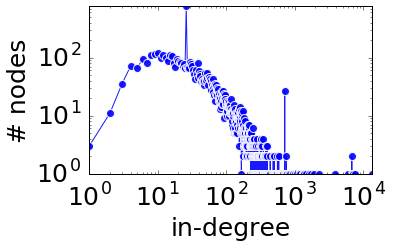

==================================milan_spiele==================================
get network: milan_spiele


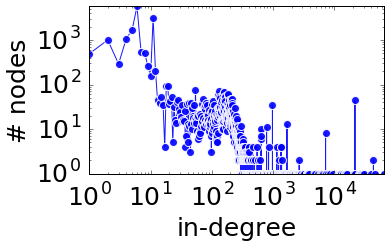

=================================getdigital_eu==================================
get network: getdigital_eu


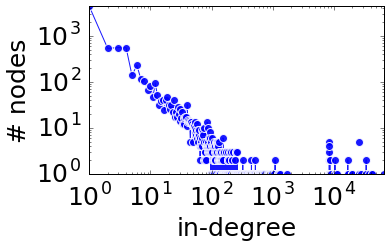

===================================thinkgeek====================================
get network: thinkgeek


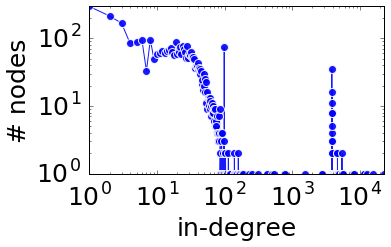

====================================bar_wiki====================================
get network: bar_wiki


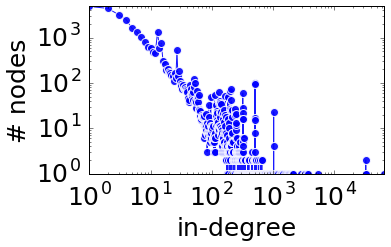

===================================tvthek_orf===================================
get network: tvthek_orf


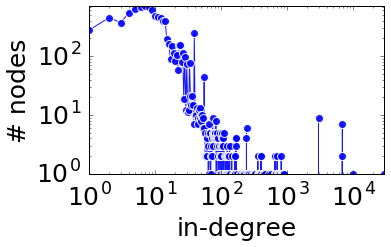

====================================daserste====================================
get network: daserste


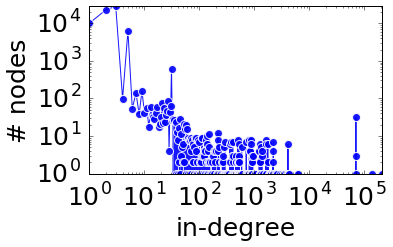

In [6]:
out_dir = 'deg_plots/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
for ds in datasets:
    network_name = ds['name']
    ds = ds.copy()
    ds.pop("name", None)
    file_name = network_name.rsplit('/', 1)[-1]
    print(file_name.center(80, '='))
    net = get_network(network_name, **ds)
    network_name, file_name = file_name, network_name
    for deg_type in ['in', 'out', 'total']:
        counts, bins = vertex_hist(net, deg_type)
        counts = counts[1:]
        bins = bins[1:-1]
        plt.plot(bins, counts, '-o', markeredgecolor='white', markeredgewidth=1, markersize=8, alpha=0.9, lw=1)#, s=40)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([bins[0], bins[-1]])
        plt.ylim([counts.min(), counts.max()])
        plt.xlabel('in-degree')
        plt.ylabel('# nodes')
        plt.tight_layout()
        plt.savefig(out_dir + network_name + '_' + deg_type + '.pdf')
        crop_pdf(out_dir + network_name + '_' + deg_type + '.pdf')
        plt.show()
    

==================================wiki4schools==================================
get network: wiki4schools
	 wiki4schools : 6796 v 646646 e
measure: in
max measure: 2737
min measure: 1
TOP limit: 176
MED limit: 78
categorize nodes
node dist
TOP 631
MED 2050
LOW 4115
urls samples---------
MED
	 http://schools-wikipedia.org/wp/i/Iraq_War.htm
	 http://schools-wikipedia.org/wp/d/Detroit.htm
	 http://schools-wikipedia.org/wp/index/fj.htm
	 http://schools-wikipedia.org/wp/p/Parliament_of_the_United_Kingdom.htm
	 http://schools-wikipedia.org/wp/index/dk.htm
	 http://schools-wikipedia.org/wp/m/Manila.htm
	 http://schools-wikipedia.org/wp/t/Tawny_Owl.htm
	 http://schools-wikipedia.org/wp/j/John_Locke.htm
	 http://schools-wikipedia.org/wp/index/jm.htm
	 http://schools-wikipedia.org/wp/a/Andy_Murray.htm
TOP
	 http://schools-wikipedia.org/wp/r/Rhodium.htm
	 http://schools-wikipedia.org/wp/1/1969.htm
	 http://schools-wikipedia.org/wp/c/Coal.htm
	 http://schools-wikipedia.org/wp/index/we.htm
	 http:

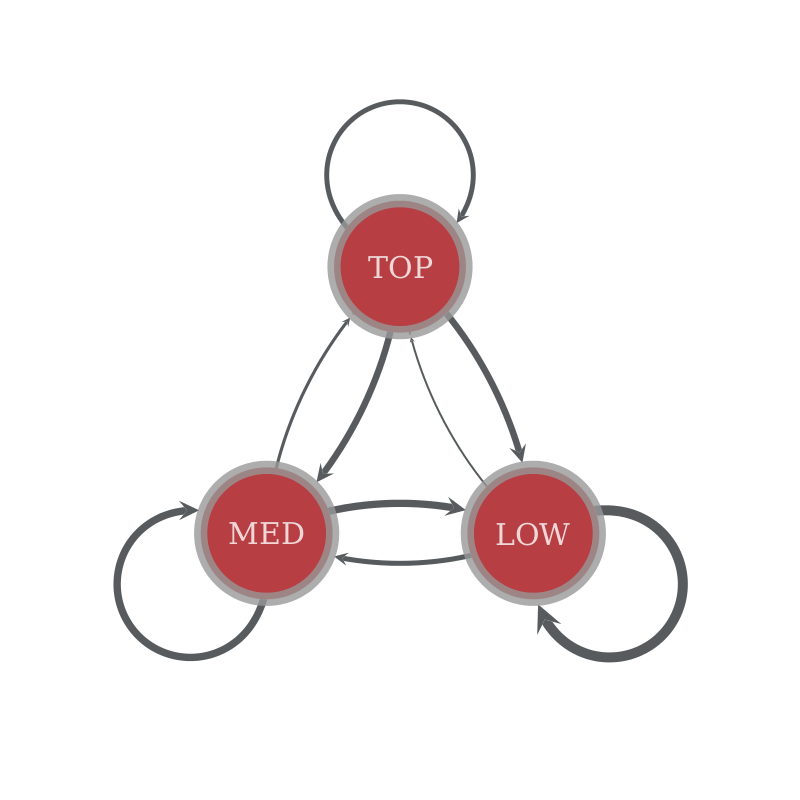

weight edges
draw biased graph


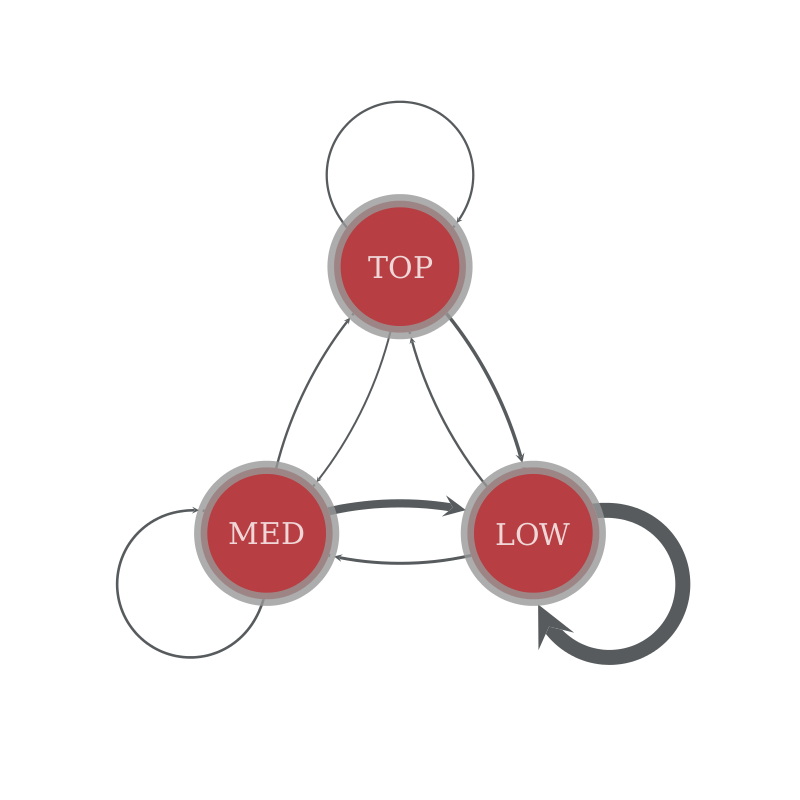

weight edges
draw biased graph


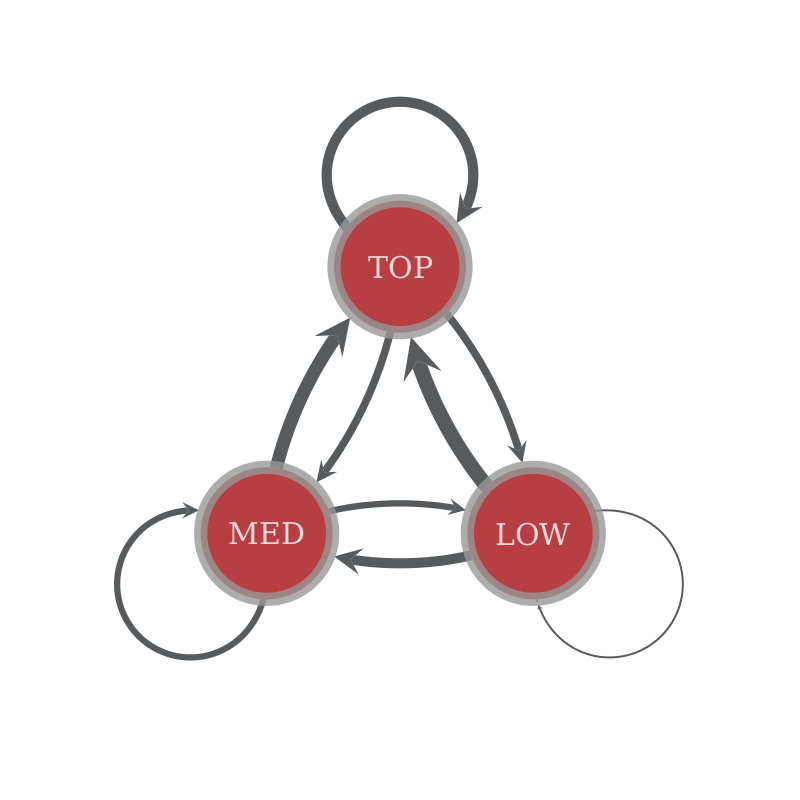

weight edges
draw biased graph


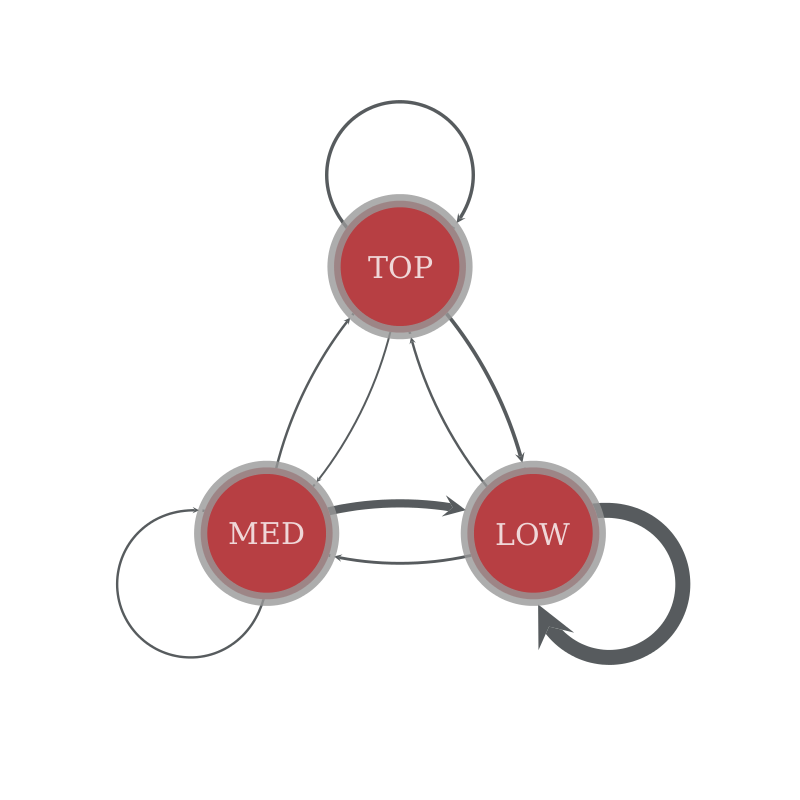

---rewired---
measure: in
max measure: 2737
min measure: 1
TOP limit: 176
MED limit: 78
categorize nodes
node dist
TOP 631
MED 2050
LOW 4115
urls samples---------
MED
	 http://schools-wikipedia.org/wp/t/T-34.htm
	 http://schools-wikipedia.org/wp/a/Atlantic_salmon.htm
	 http://schools-wikipedia.org/wp/c/Charles_I_of_England.htm
	 http://schools-wikipedia.org/wp/index/n.htm
	 http://schools-wikipedia.org/wp/t/Technology.htm
	 http://schools-wikipedia.org/wp/h/History_of_the_Royal_Australian_Navy.htm
	 http://schools-wikipedia.org/wp/a/Authorized_King_James_Version.htm
	 http://schools-wikipedia.org/wp/h/Humpback_whale.htm
	 http://schools-wikipedia.org/wp/1/1788.htm
	 http://schools-wikipedia.org/wp/d/Dune.htm
TOP
	 http://schools-wikipedia.org/wp/s/Slovenia.htm
	 http://schools-wikipedia.org/wp/index/mc.htm
	 http://schools-wikipedia.org/wp/1/1931.htm
	 http://schools-wikipedia.org/wp/t/Thallium.htm
	 http://schools-wikipedia.org/wp/j/Jews.htm
	 http://schools-wikipedia.org/wp/h/History

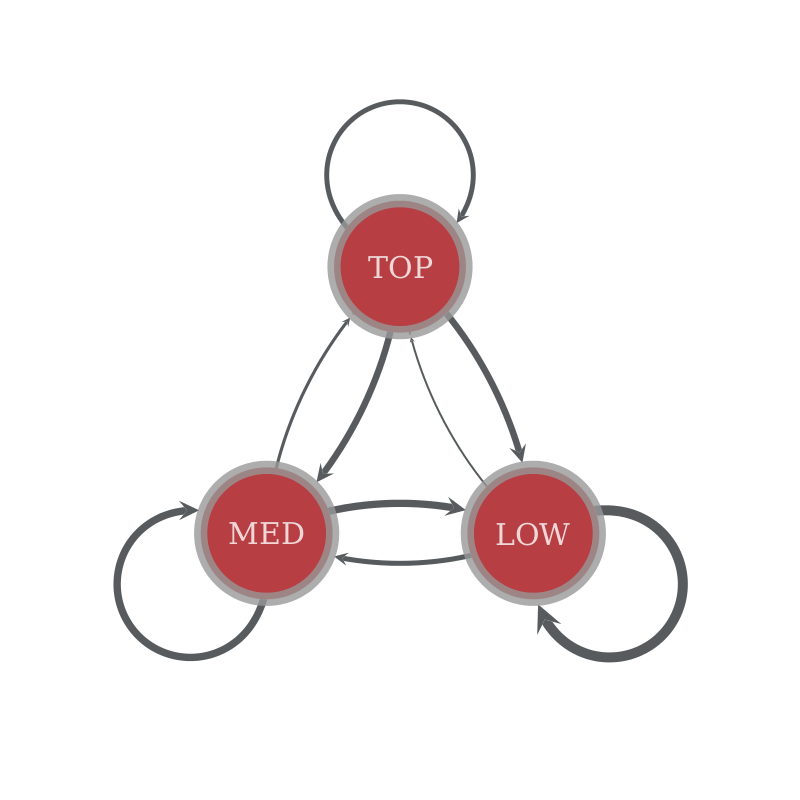

weight edges
draw biased graph


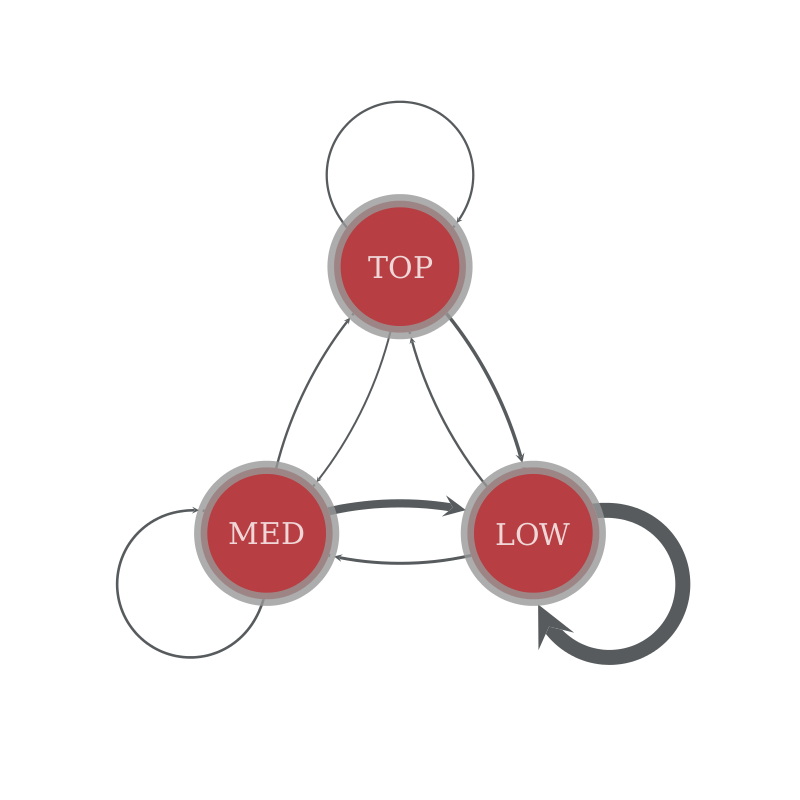

weight edges
draw biased graph


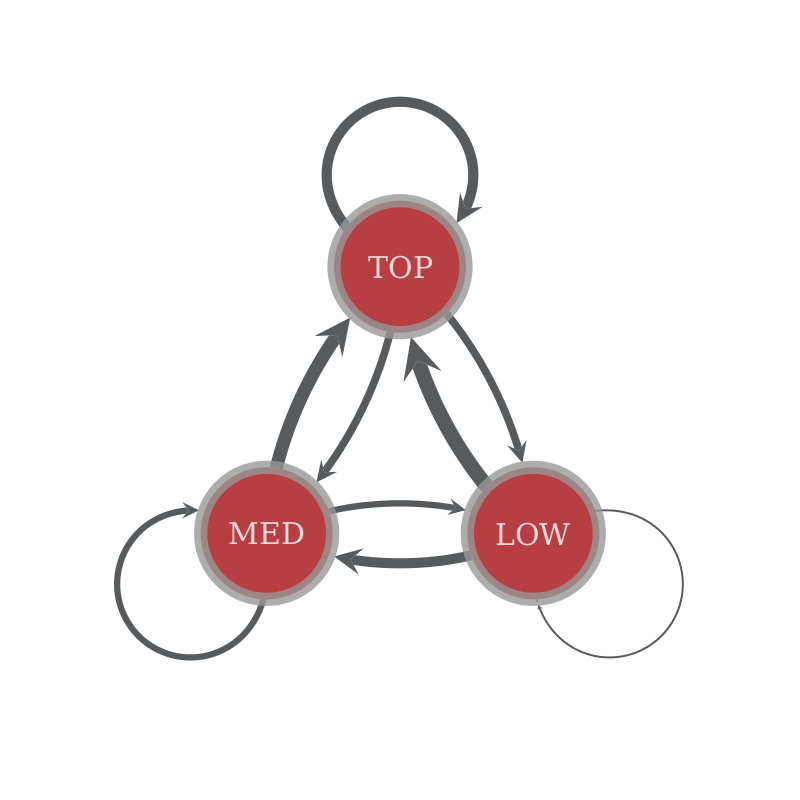

weight edges
draw biased graph


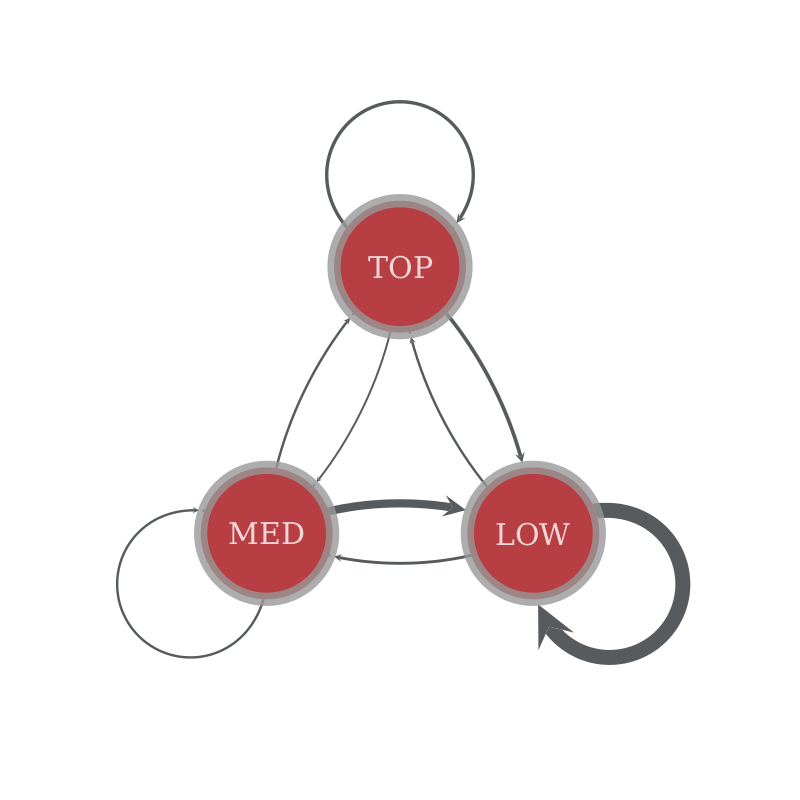

==================================milan_spiele==================================
get network: milan_spiele
	 milan_spiele : 21566 v 3128693 e
measure: in
max measure: 1118
min measure: 60
TOP limit: 147
MED limit: 133
categorize nodes
node dist
TOP 4233
MED 6929
LOW 10404
urls samples---------
MED
	 http://www.milan-spiele.de/fantasy-flight-games-m-31.html?page=12&perPage=10&sort=1a
	 http://www.milan-spiele.de/nach-anzahl-vier-spieler-c-93_97.html?page=194&sort=1a&perPage=10
	 http://www.milan-spiele.de/nach-anzahl-zwei-spieler-c-93_95.html?page=30&sort=1a&perPage=10
	 http://www.milan-spiele.de/ravensburger-m-64.html?page=3&sort=1a&perPage=10
	 http://www.milan-spiele.de/nach-anzahl-drei-spieler-c-93_96.html?page=224&perPage=10&sort=1a
	 http://www.milan-spiele.de/nach-alter-jahren-c-115_126.html?page=8&perPage=10&sort=1a
	 http://www.milan-spiele.de/nach-anzahl-vier-spieler-c-93_97.html?page=52&sort=1a
	 http://www.milan-spiele.de/nach-anzahl-vier-spieler-c-93_97.html?page=301&perPa

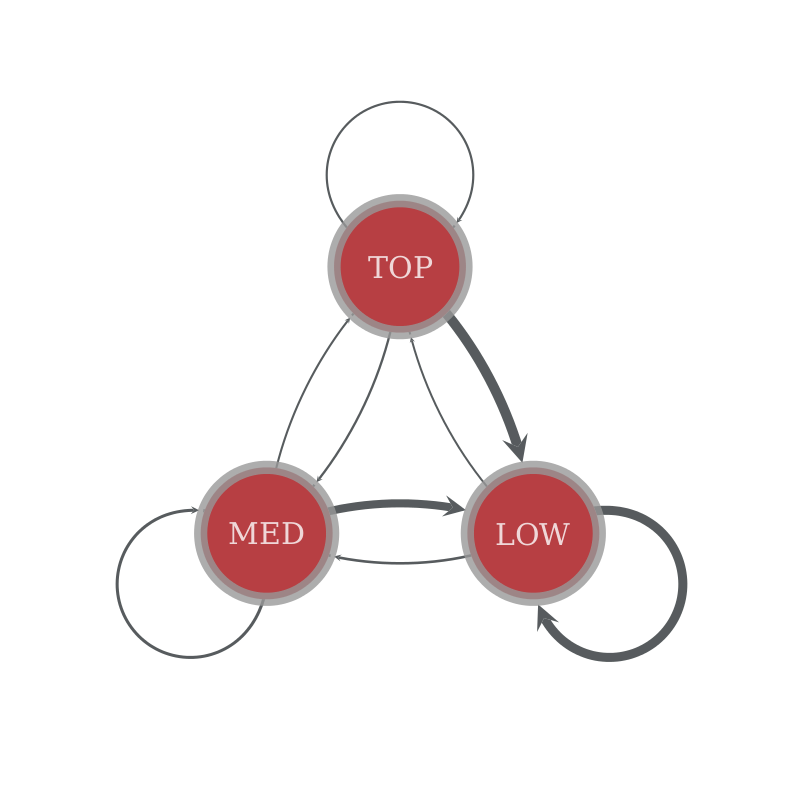

weight edges
draw biased graph


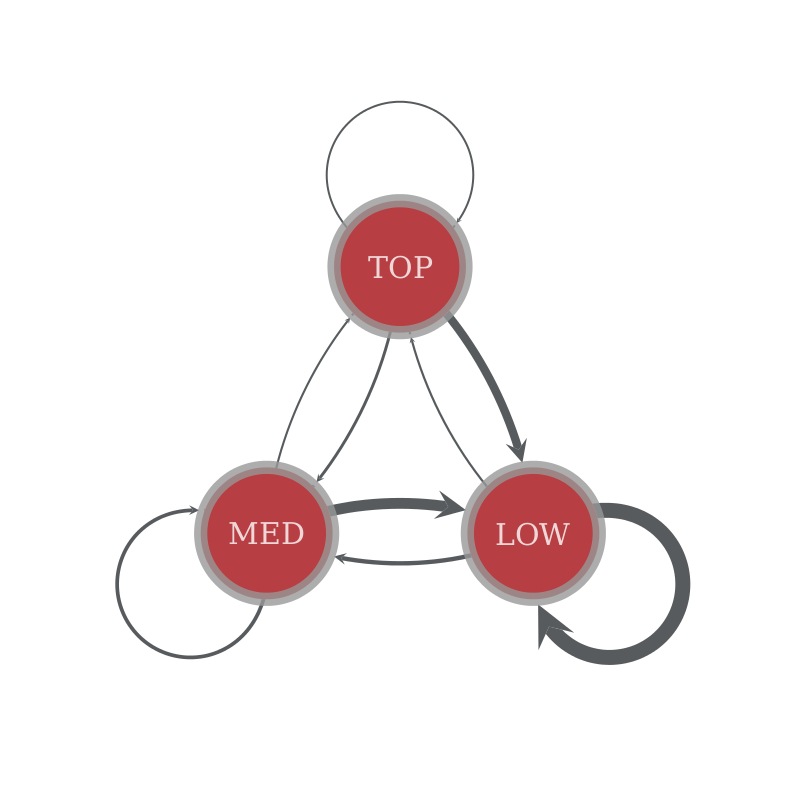

weight edges
draw biased graph


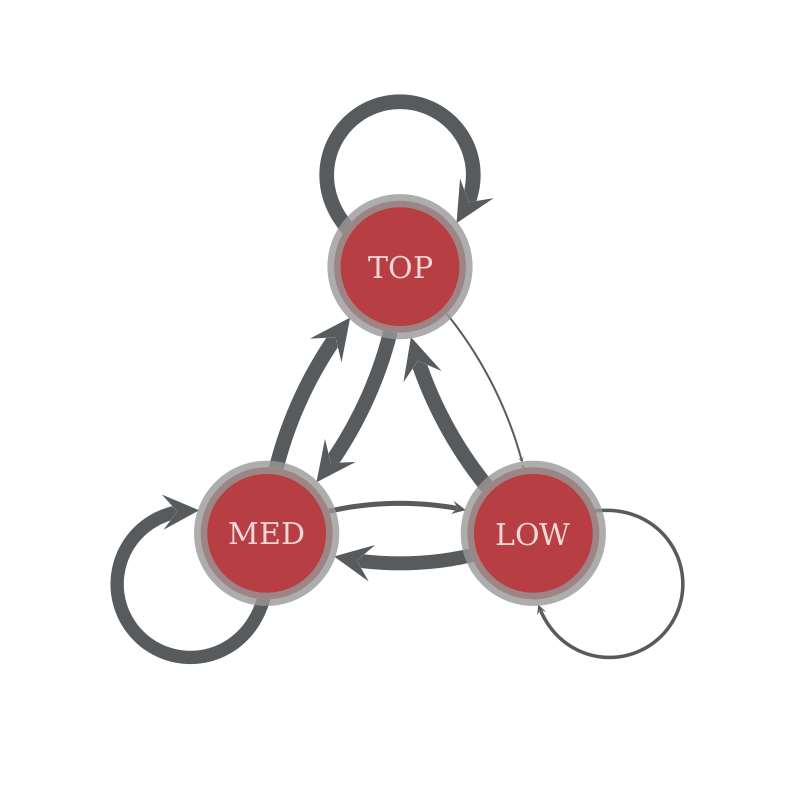

weight edges
draw biased graph


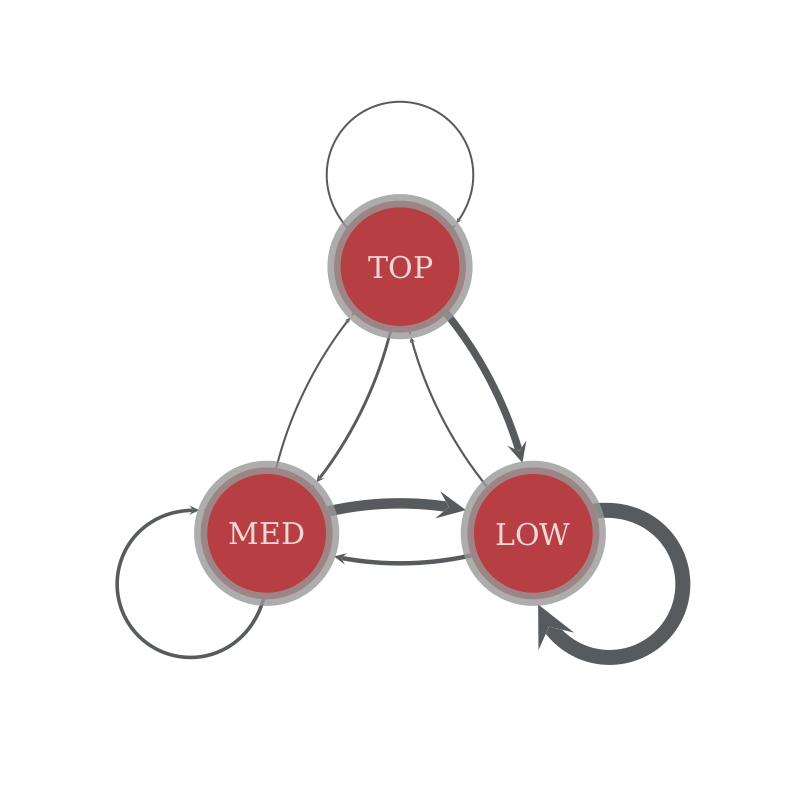

---rewired---
measure: in
max measure: 1118
min measure: 60
TOP limit: 147
MED limit: 133
categorize nodes
node dist
TOP 4233
MED 6929
LOW 10404
urls samples---------
MED
	 http://www.milan-spiele.de/nach-anzahl-sieben-mehr-c-93_100.html?page=35&sort=1a
	 http://www.milan-spiele.de/neuheiten-essen-c-670.html?page=11&sort=1a&perPage=10
	 http://www.milan-spiele.de/nach-anzahl-sechs-spieler-c-93_99.html?page=77&perPage=10&sort=1a
	 http://www.milan-spiele.de/neuheiten-nuernberg-c-741.html?page=3&perPage=10&sort=1a
	 http://www.milan-spiele.de/nach-anzahl-fuenf-spieler-c-93_98.html?page=111&sort=1a
	 http://www.milan-spiele.de/nach-anzahl-fuenf-spieler-c-93_98.html?page=170&perPage=10&sort=1a
	 http://www.milan-spiele.de/nach-anzahl-sechs-spieler-c-93_99.html?page=99&perPage=10&sort=1a
	 http://www.milan-spiele.de/neuheiten-demnaechst-c-102_158.html?page=13&perPage=10&sort=1a
	 http://www.milan-spiele.de/nach-anzahl-sechs-spieler-c-93_99.html?page=4&sort=1a&perPage=10
	 http://www.milan-s

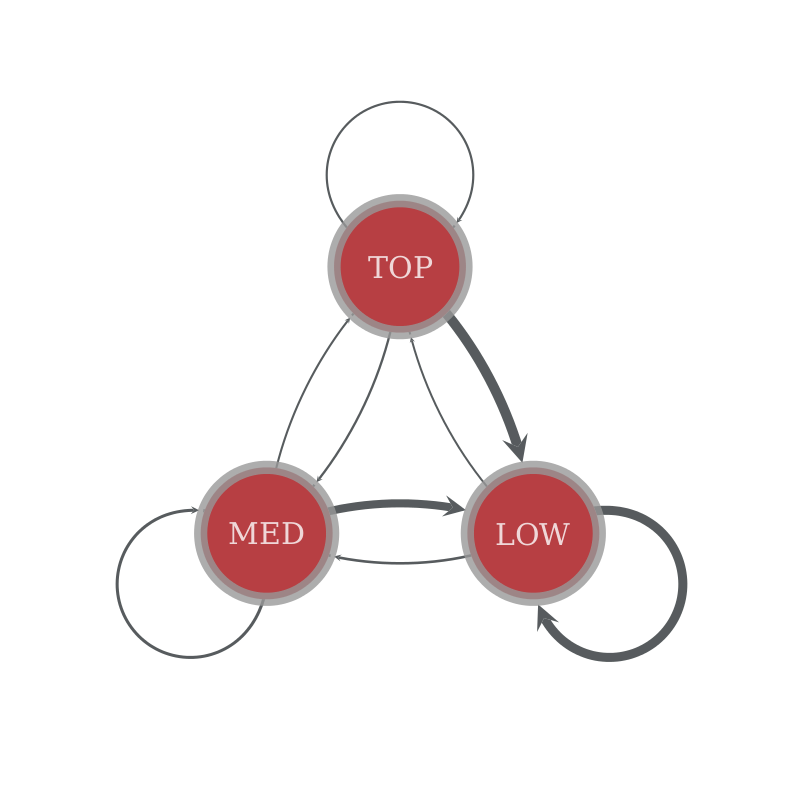

weight edges
draw biased graph


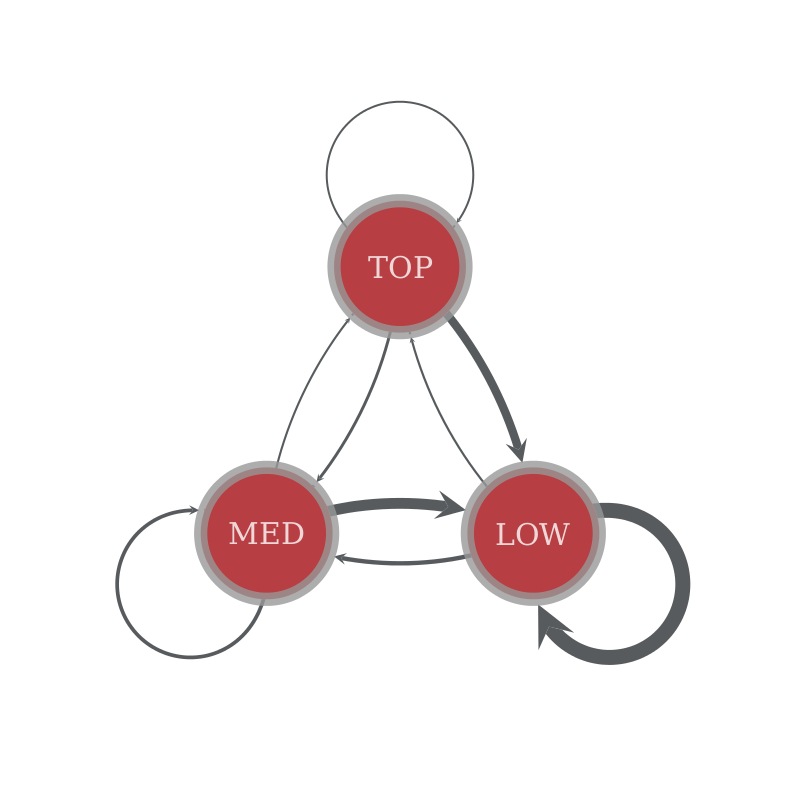

weight edges
draw biased graph


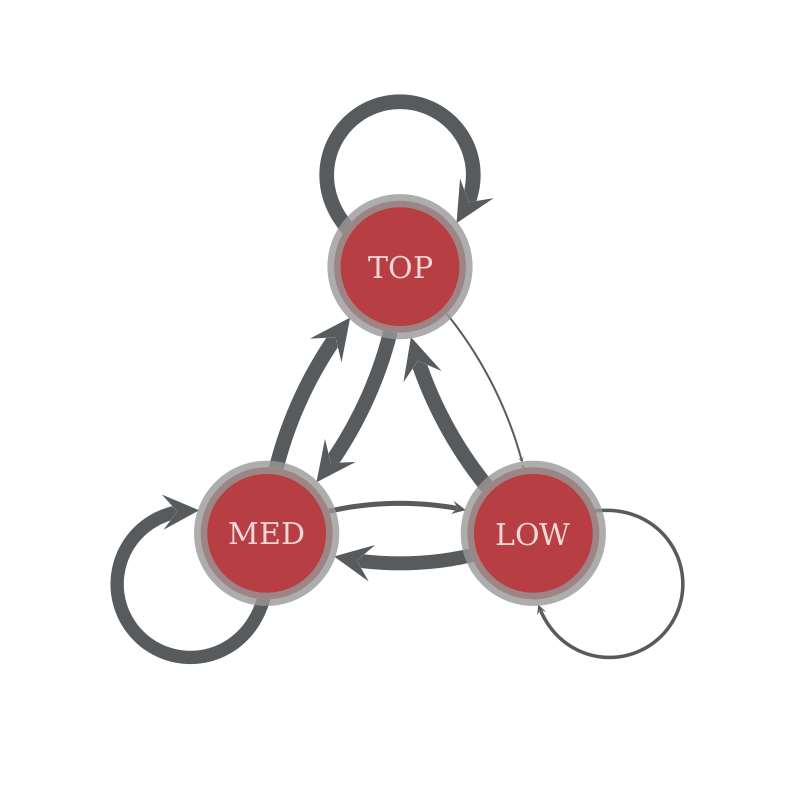

weight edges
draw biased graph


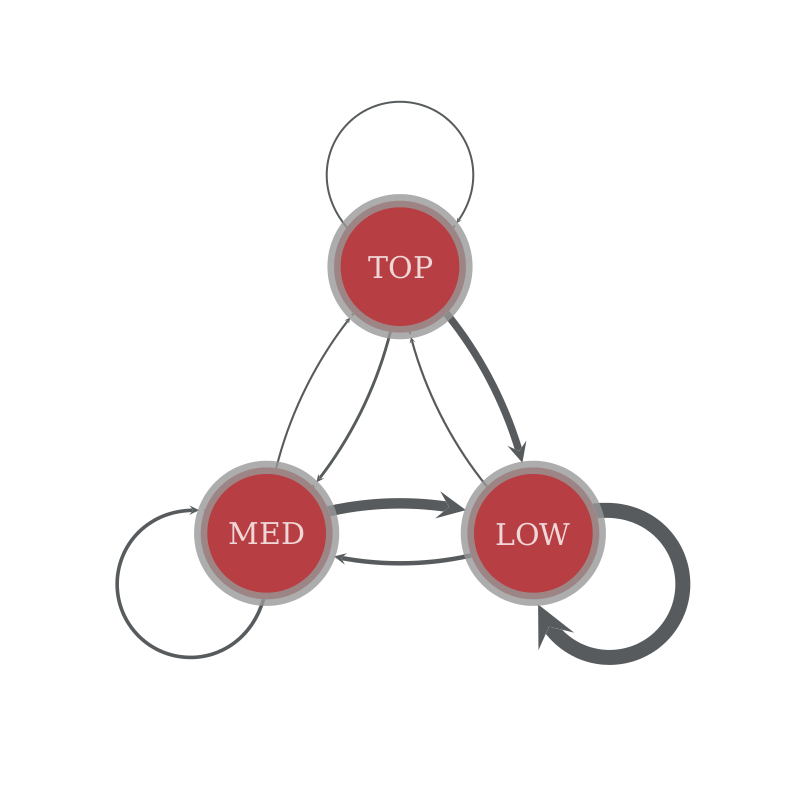

=================================getdigital_eu==================================
get network: getdigital_eu
	 getdigital_eu : 8477 v 1471764 e
measure: in
max measure: 1100
min measure: 146
TOP limit: 177
MED limit: 169
categorize nodes
node dist
TOP 2930
MED 2589
LOW 2958
urls samples---------
MED
	 www.getdigital.eu/gifts/science-fiction/men/merchandise/decoration
	 www.getdigital.eu/gifts/bed-room/to-put-up
	 www.getdigital.eu/BigTrak---programmable-Retro-Truck.html
	 www.getdigital.eu/gifts/science-fiction/men/food-and-drinks
	 www.getdigital.eu/shop/star-wars/at-home/films-and-tv-series
	 www.getdigital.eu/shop/useful-stuff/office/it-administration
	 www.getdigital.eu/shop/science-fiction/merchandise/star-wars/led-and-laser
	 www.getdigital.eu/gifts/men/geek-lifestyle/films-and-tv-series
	 www.getdigital.eu/gifts/funny/geek-lifestyle
	 www.getdigital.eu/gifts/it-admin
TOP
	 www.getdigital.eu/shop/science-fiction/computer-games/geek-lifestyle
	 www.getdigital.eu/shop/useful-stuff/f

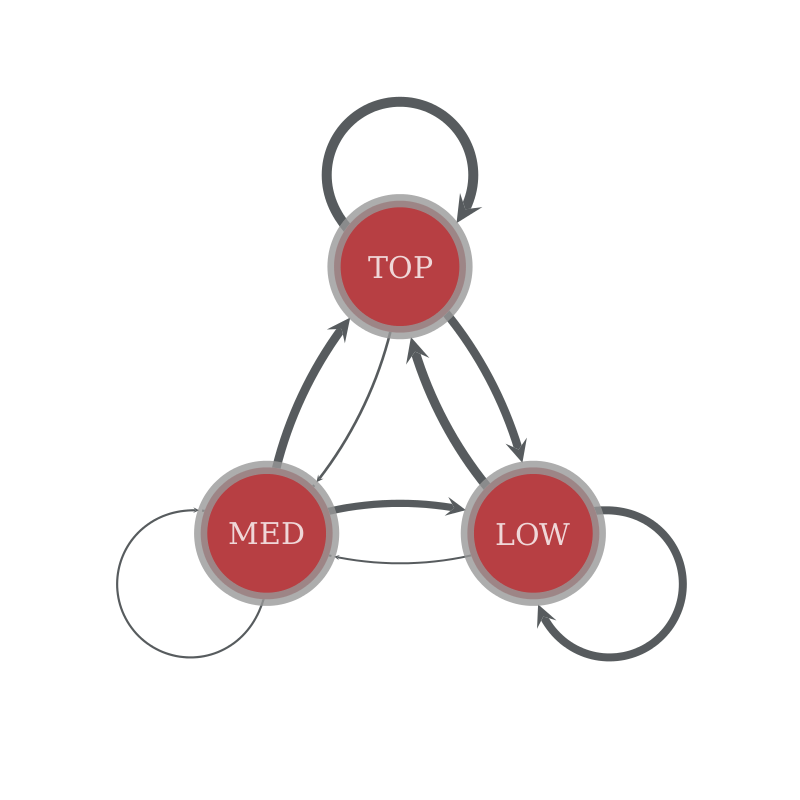

weight edges
draw biased graph


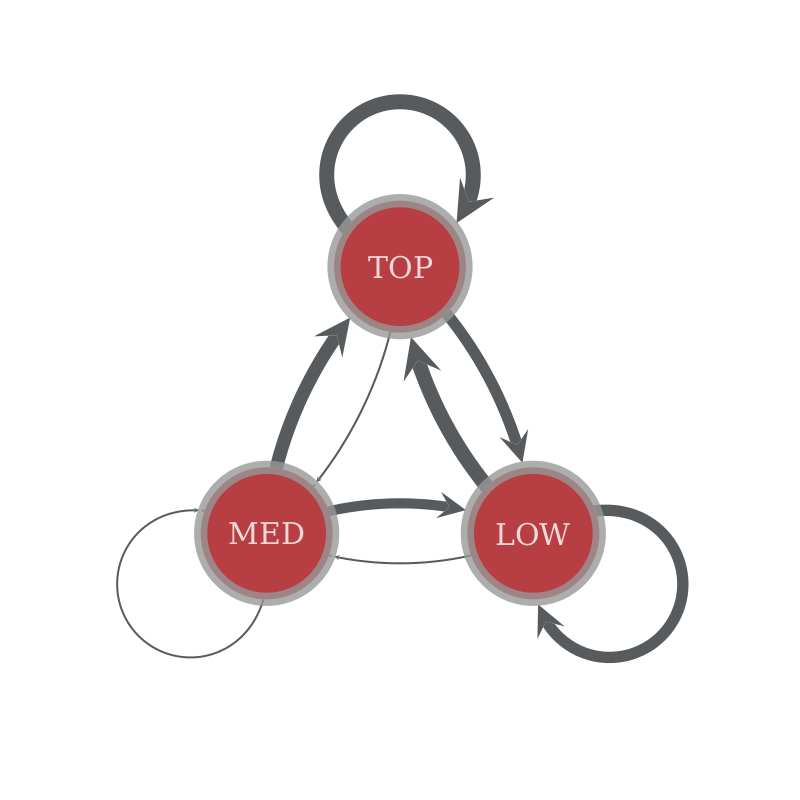

weight edges
draw biased graph


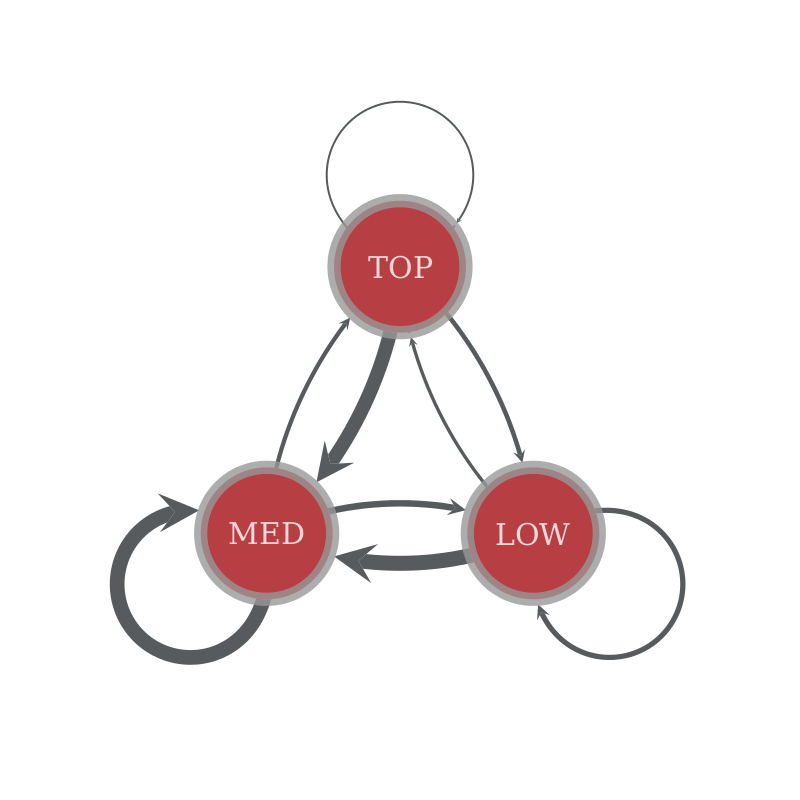

weight edges
draw biased graph


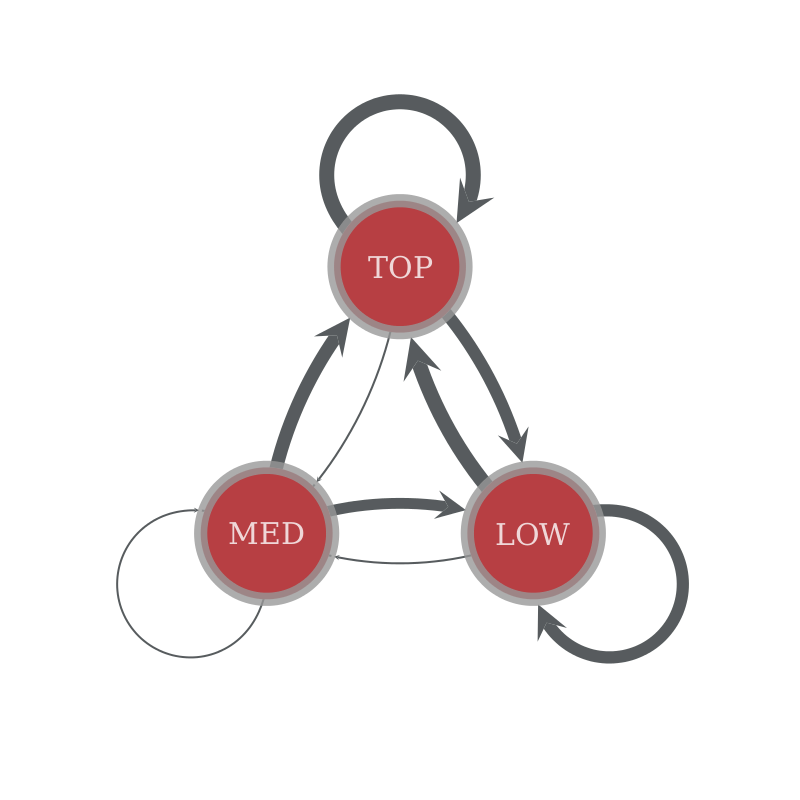

---rewired---
measure: in
max measure: 1100
min measure: 146
TOP limit: 177
MED limit: 169
categorize nodes
node dist
TOP 2930
MED 2589
LOW 2958
urls samples---------
MED
	 www.getdigital.eu/gifts/star-wars/fun-and-games/films-and-tv-series
	 www.getdigital.eu/gifts/science-fiction/merchandise/films-and-tv-series/men/food-and-drinks
	 www.getdigital.eu/gifts/nerd-lifestyle/gadgets
	 www.getdigital.eu/Property-of-Physics-Department.html
	 www.getdigital.eu/shop/pac-man
	 www.getdigital.eu/gifts/computer-games/useful-stuff/pac-man
	 www.getdigital.eu/gifts/useful-stuff/science-fiction/star-trek
	 www.getdigital.eu/gifts/useful-stuff/merchandise/office
	 www.getdigital.eu/gifts/decoration/christmas-gifts/science-fiction
	 www.getdigital.eu/shop/food-and-drinks/retro
TOP
	 www.getdigital.eu/shop/computer-games/films-and-tv-series
	 www.getdigital.eu/gifts/science-fiction/special
	 www.getdigital.eu/gifts/clothing/geek-lifestyle/computer-games/adventures
	 www.getdigital.eu/gifts/birthday/d

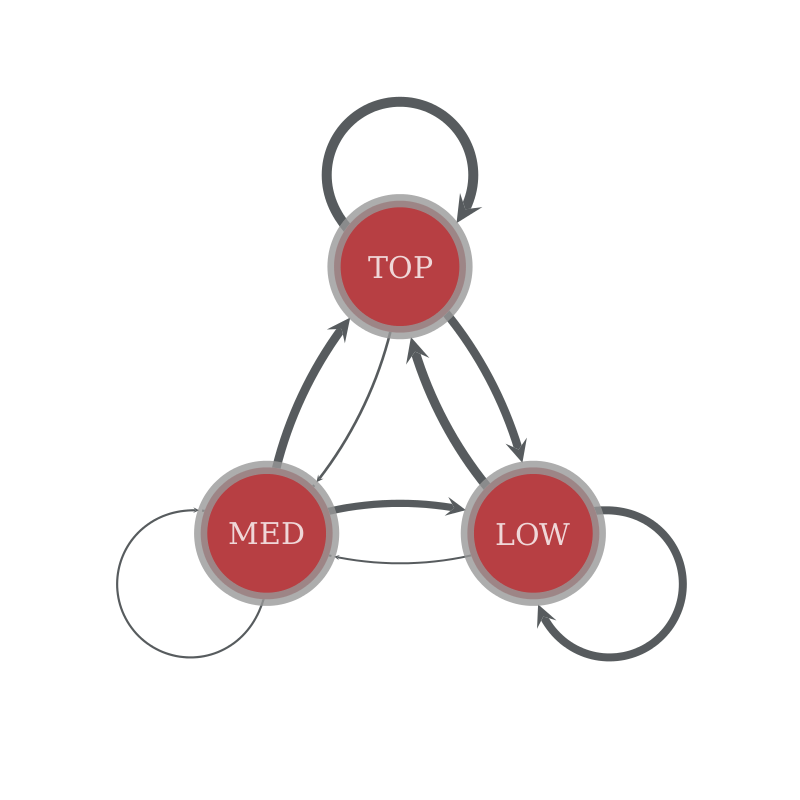

weight edges
draw biased graph


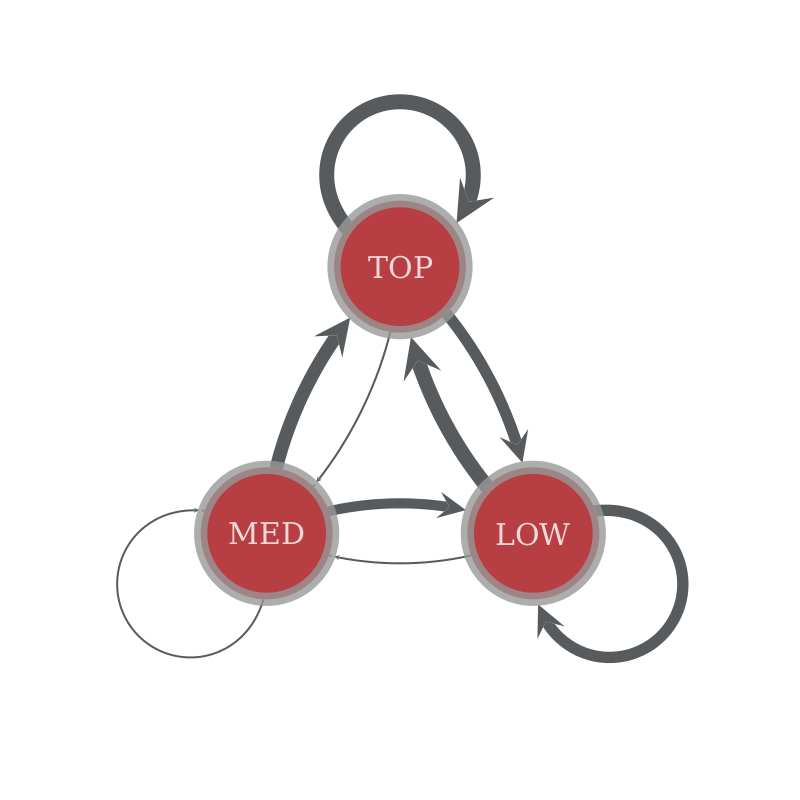

weight edges
draw biased graph


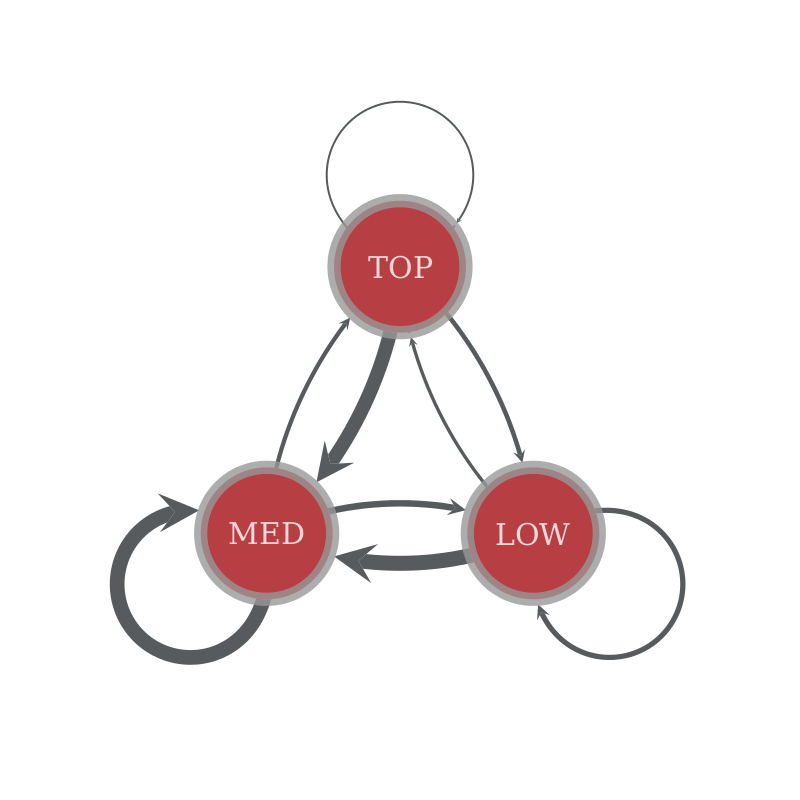

weight edges
draw biased graph


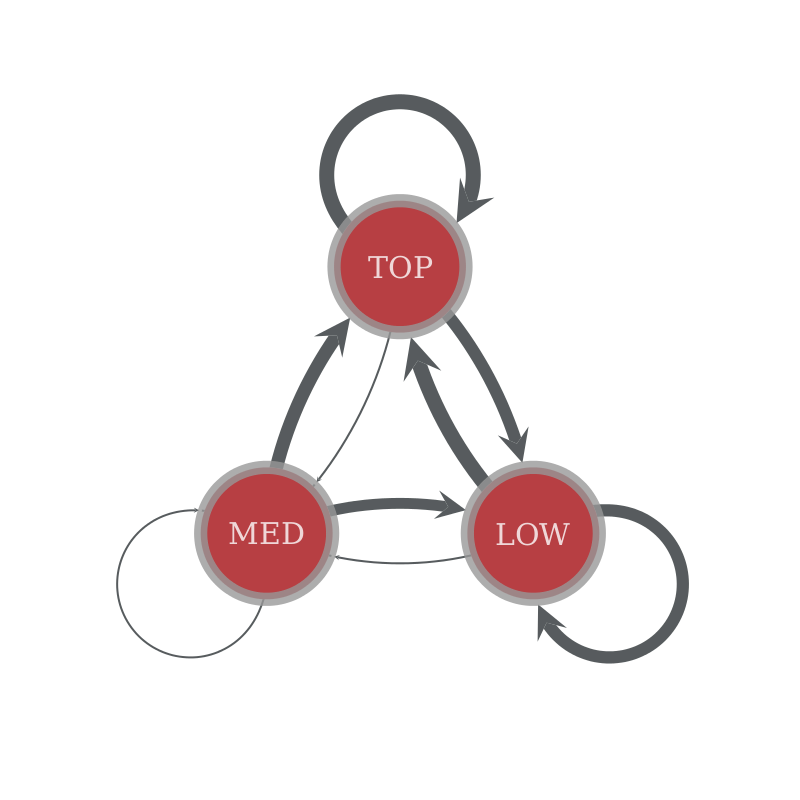

===================================thinkgeek====================================
get network: thinkgeek
	 thinkgeek : 3884 v 1002226 e
measure: in
max measure: 662
min measure: 1
TOP limit: 258
MED limit: 251
categorize nodes
node dist
TOP 1368
MED 1246
LOW 1270
urls samples---------
MED
	 http://www.thinkgeek.com/product/2035/?pfm=homeoffice_featured_2035_3
	 http://www.thinkgeek.com/product/ee85/
	 http://www.thinkgeek.com/product/19c6/?pfm=geek-kids_newest_19c6_7
	 http://www.thinkgeek.com/product/3Egg/
	 http://www.thinkgeek.com/product/hrst/
	 http://www.thinkgeek.com/product/1f95/
	 http://www.thinkgeek.com/product/1fa3/
	 http://www.thinkgeek.com/product/13d7/
	 http://www.thinkgeek.com/product/1124/
	 http://www.thinkgeek.com/product/f33d/?pfm=_Home__4__f33d
TOP
	 http://www.thinkgeek.com/blog/2010/02/
	 http://www.thinkgeek.com/product/1df9/
	 http://www.thinkgeek.com/product/1cde/
	 http://www.thinkgeek.com/product/1d97/
	 http://www.thinkgeek.com/product/215e/
	 http://www.t

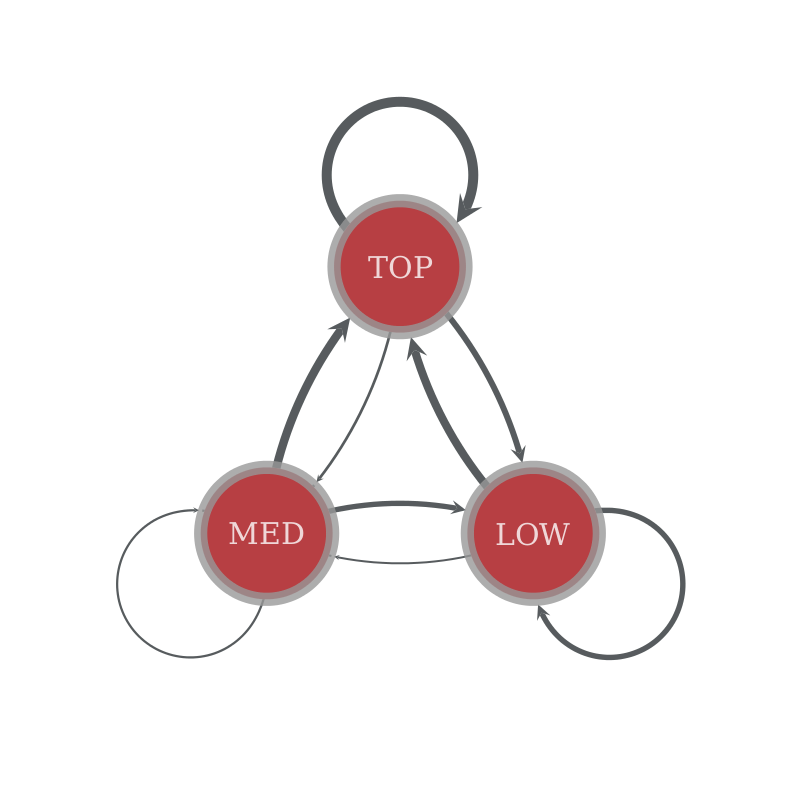

weight edges
draw biased graph


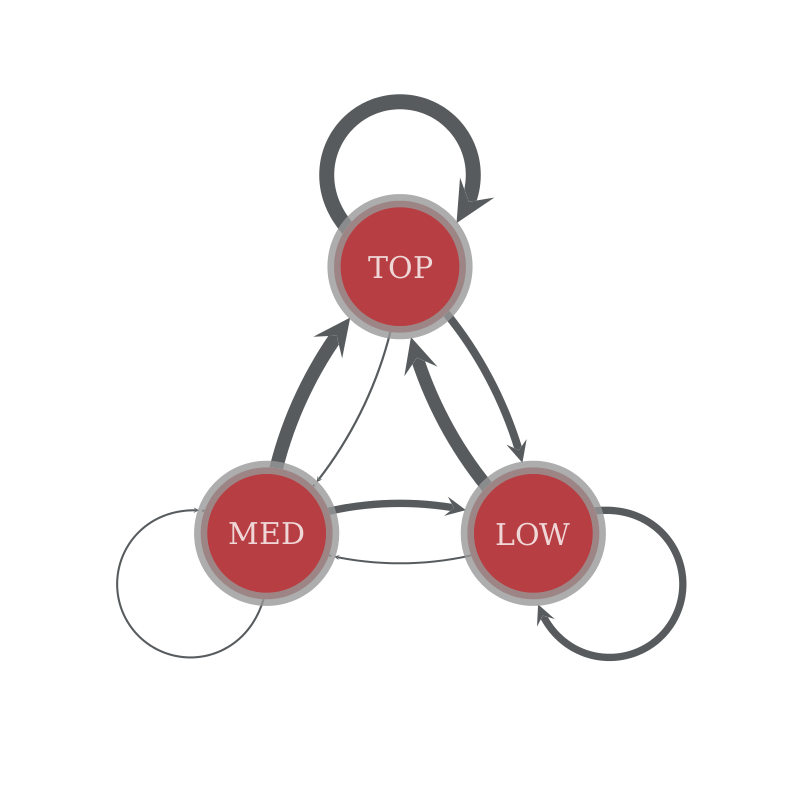

weight edges
draw biased graph


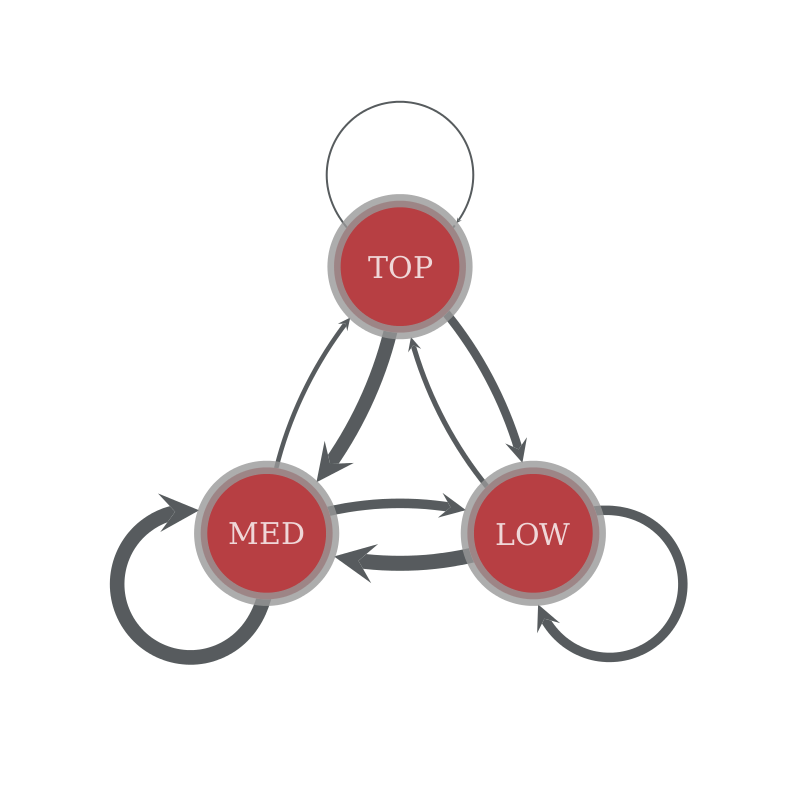

weight edges
draw biased graph


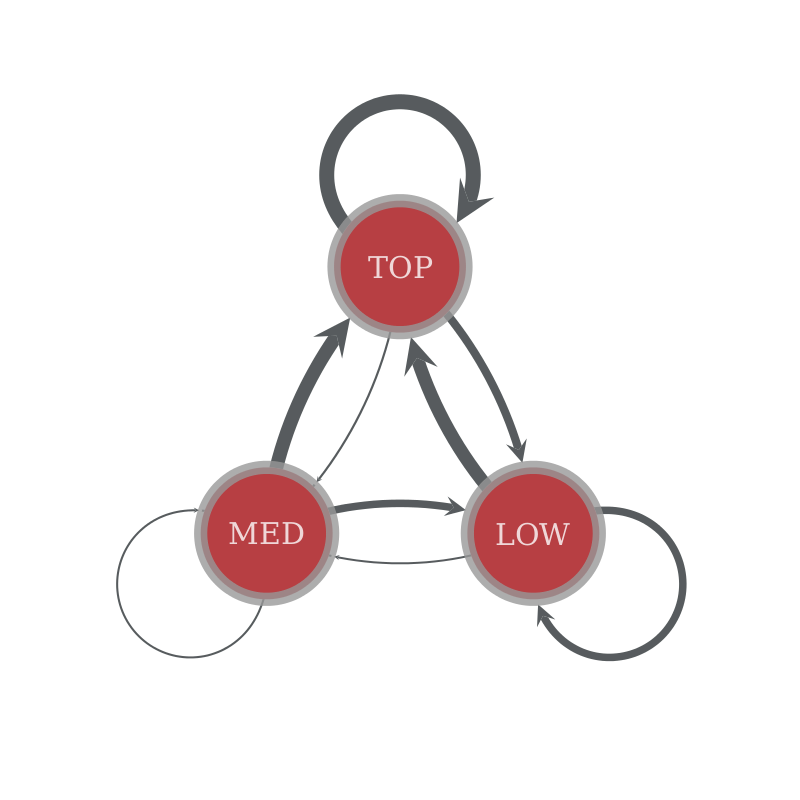

---rewired---
measure: in
max measure: 662
min measure: 1
TOP limit: 258
MED limit: 251
categorize nodes
node dist
TOP 1368
MED 1246
LOW 1270
urls samples---------
MED
	 http://www.thinkgeek.com/product/hrrr/
	 http://www.thinkgeek.com/product/19c6/?pfm=geek-kids_newest_19c6_7
	 http://www.thinkgeek.com/product/1f01/
	 http://www.thinkgeek.com/product/e73b/action/21b9567/
	 http://www.thinkgeek.com/product/eea5/?pfm=Featured_2_eea5
	 http://www.thinkgeek.com/product/1b3f/
	 http://www.thinkgeek.com/product/2147/
	 http://www.thinkgeek.com/product/1bb2/
	 http://www.thinkgeek.com/product/1ec3/
	 http://www.thinkgeek.com/product/ec4a/
TOP
	 http://www.thinkgeek.com/product/hsht/
	 http://www.thinkgeek.com/electronics-gadgets/newest/desc/2/100
	 http://www.thinkgeek.com/product/2032/
	 http://www.thinkgeek.com/product/2158/
	 http://www.thinkgeek.com/product/1cc4/
	 http://www.thinkgeek.com/product/htsh/?pfm=HP_ProdTab_5_8_Mother'sDayGifts_htsh
	 http://www.thinkgeek.com/geektoys/other-le

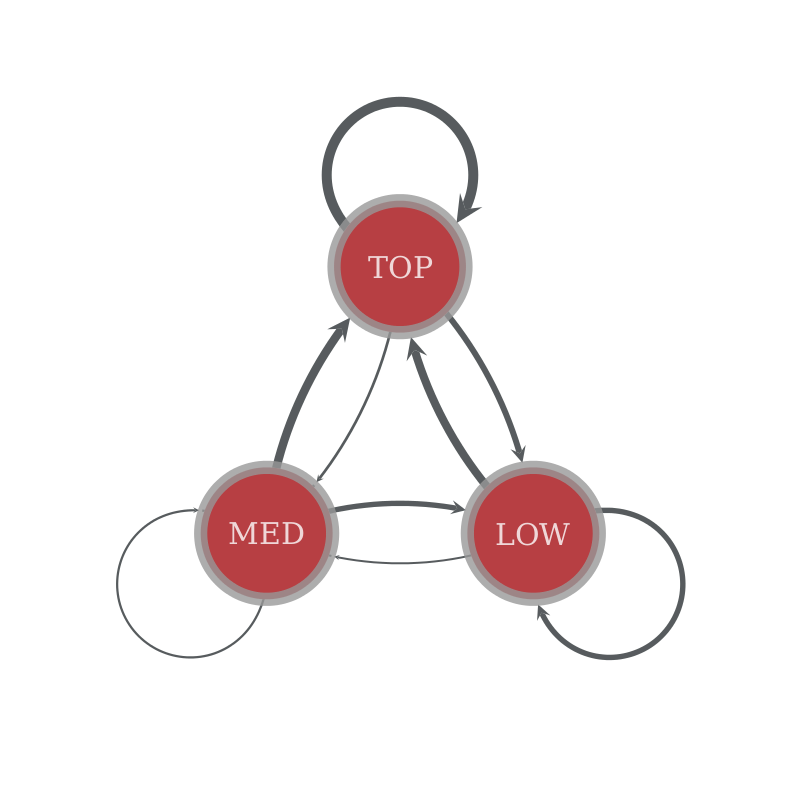

weight edges
draw biased graph


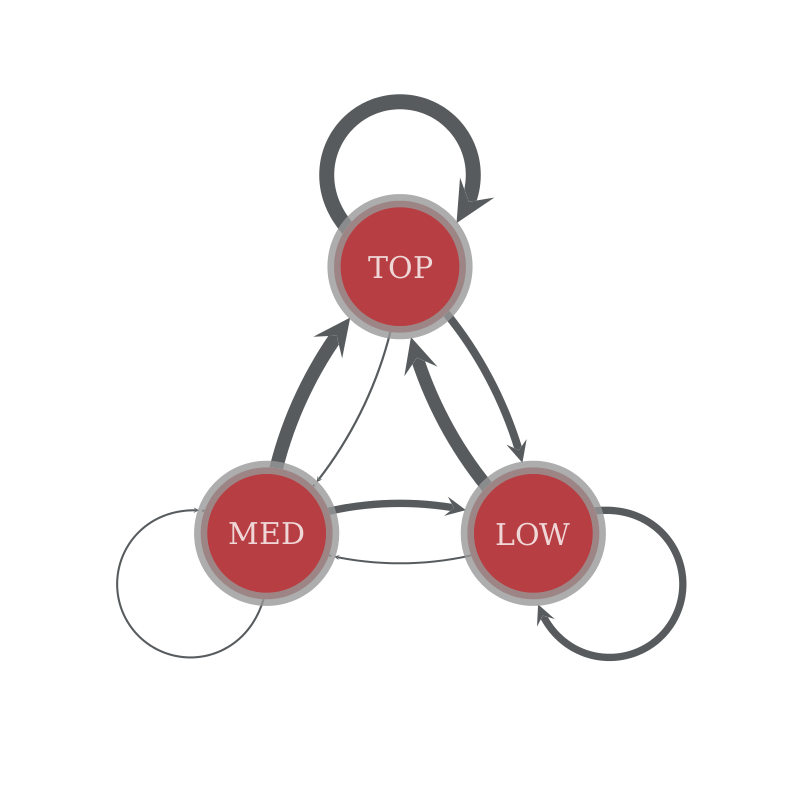

weight edges
draw biased graph


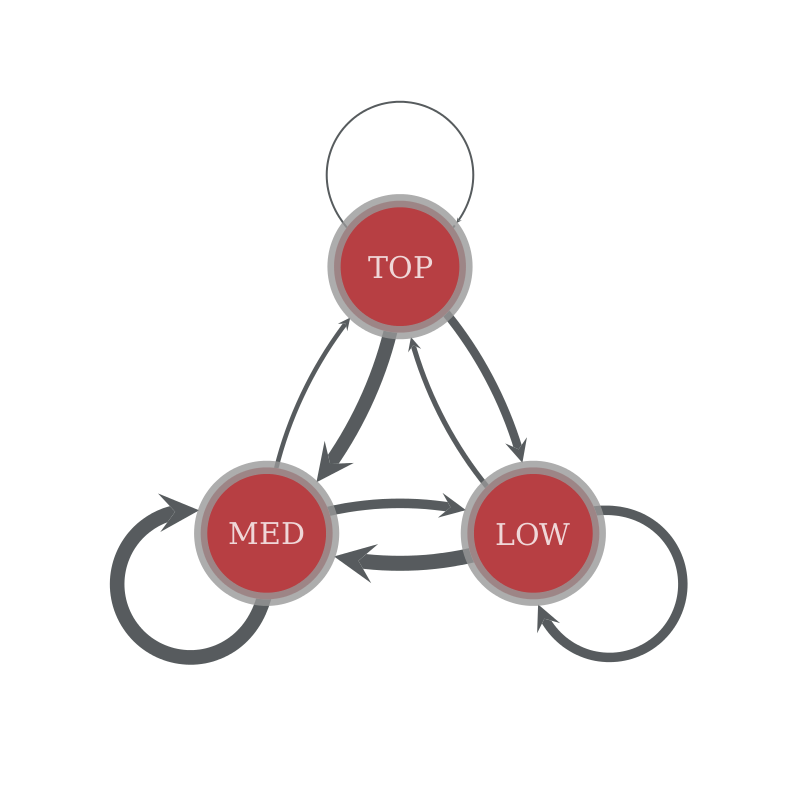

weight edges
draw biased graph


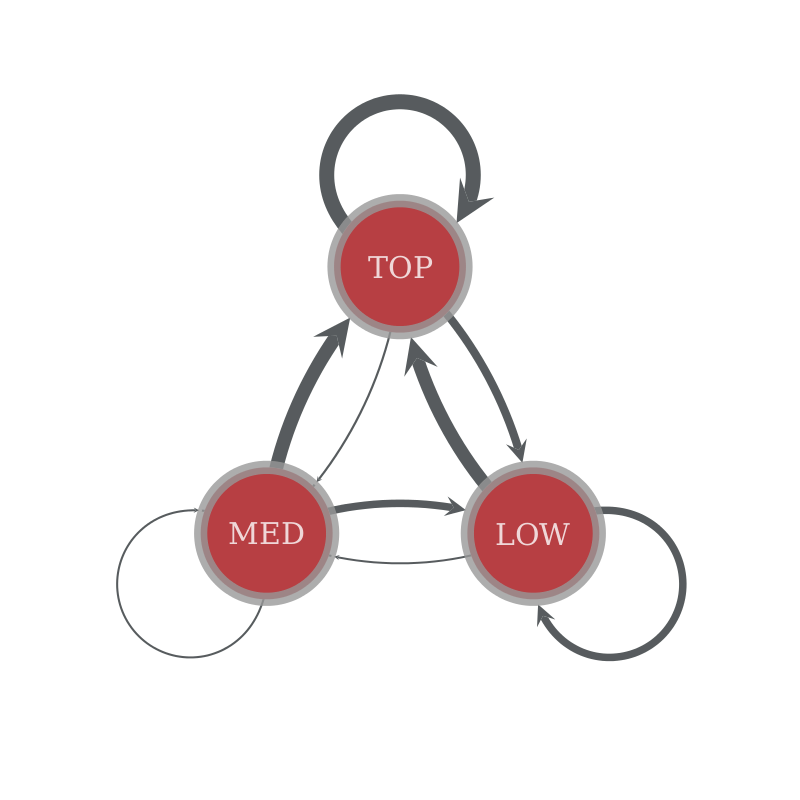

====================================bar_wiki====================================
get network: bar_wiki
	 bar_wiki : 32734 v 1324839 e
measure: in
max measure: 2134
min measure: 10
TOP limit: 117
MED limit: 33
categorize nodes
node dist
TOP 2534
MED 6595
LOW 23605
urls samples---------
MED
	 https://bar.wikipedia.org/wiki/Biografien/Ks
	 https://bar.wikipedia.org/wiki/Taufkira_(ba_Minga)
	 https://bar.wikipedia.org/wiki/Kategorie:1870
	 https://bar.wikipedia.org/wiki/Palm_Beach_County
	 https://bar.wikipedia.org/wiki/Manx
	 https://bar.wikipedia.org/wiki/Nestroy
	 https://bar.wikipedia.org/wiki/St._Landry_Parish
	 https://bar.wikipedia.org/wiki/Listn_vo_de_Countys_z_West_Virginia
	 https://bar.wikipedia.org/wiki/Liste_der_St%C3%A4dte_in_New_Jersey
	 https://bar.wikipedia.org/wiki/Schwammerl
TOP
	 https://bar.wikipedia.org/wiki/Biografien/Ie
	 https://bar.wikipedia.org/wiki/Ector_County,_Texas
	 https://bar.wikipedia.org/wiki/Wikipedia:L%C3%B6schkandidaten/Archiv/2008/1
	 https://bar.wik

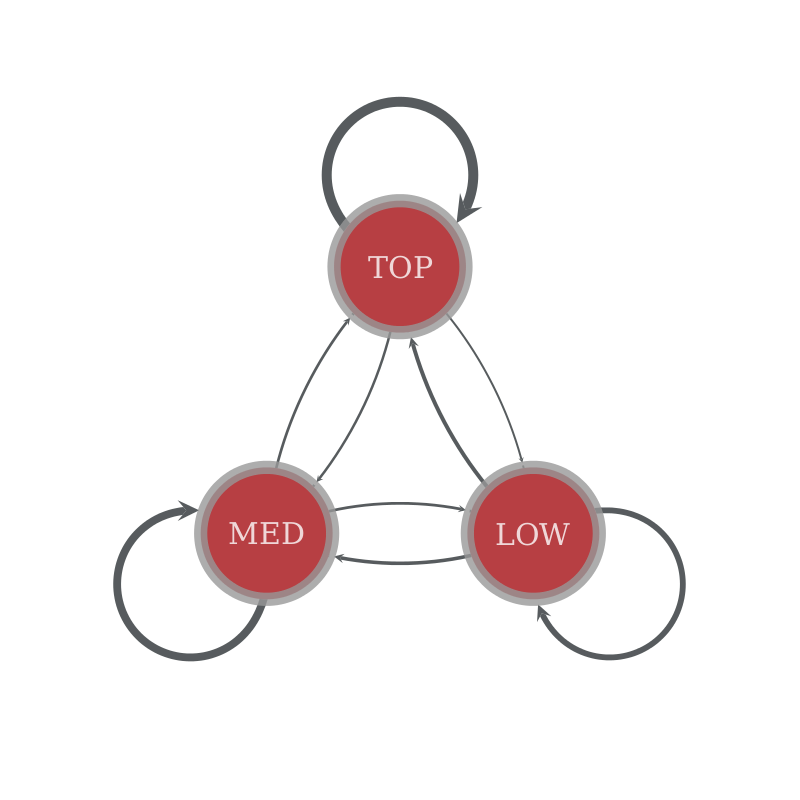

weight edges
draw biased graph


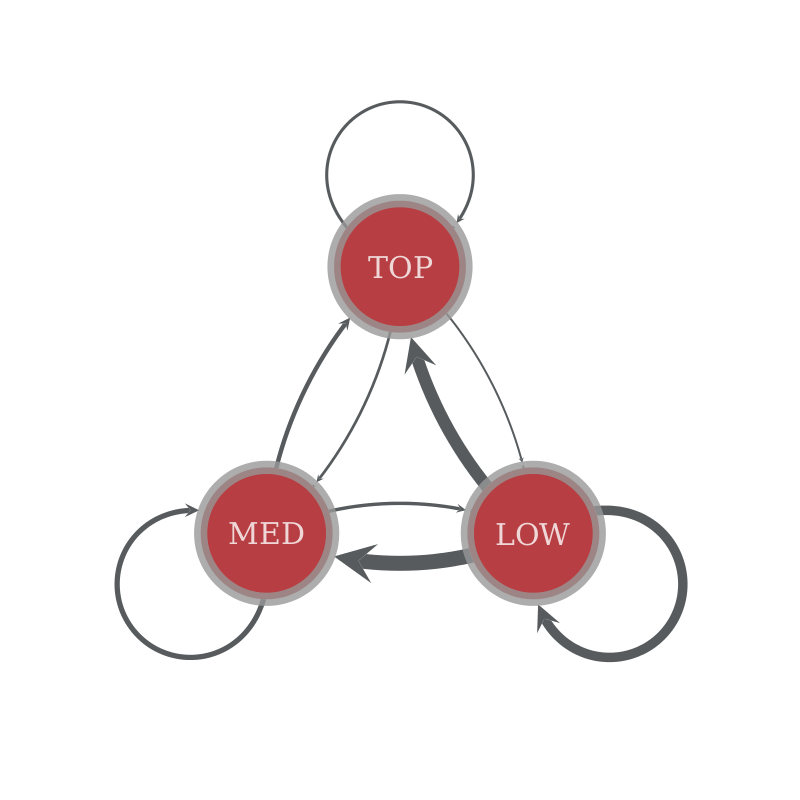

weight edges
draw biased graph


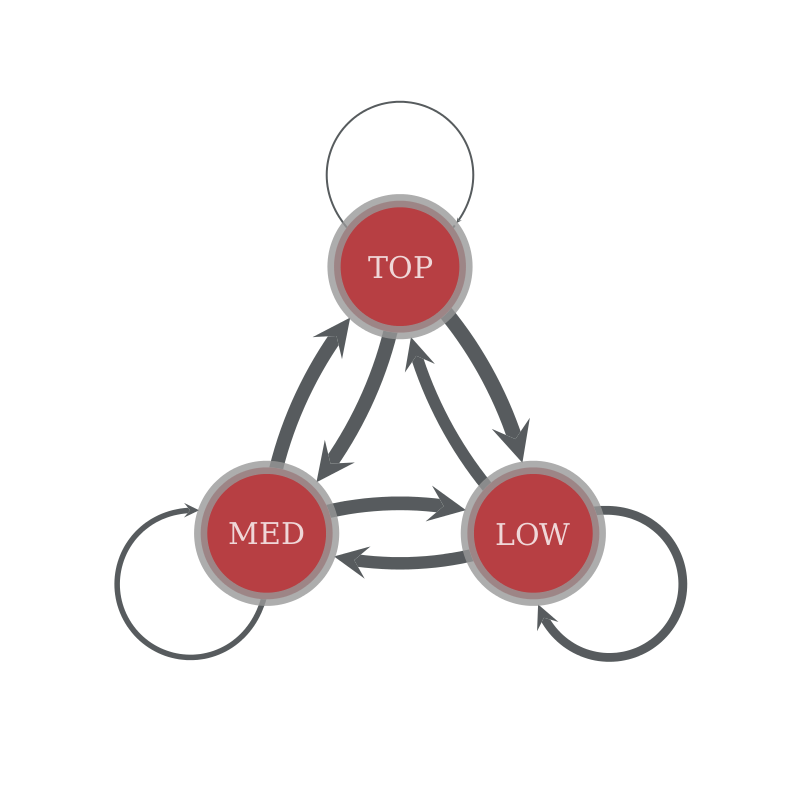

weight edges
draw biased graph


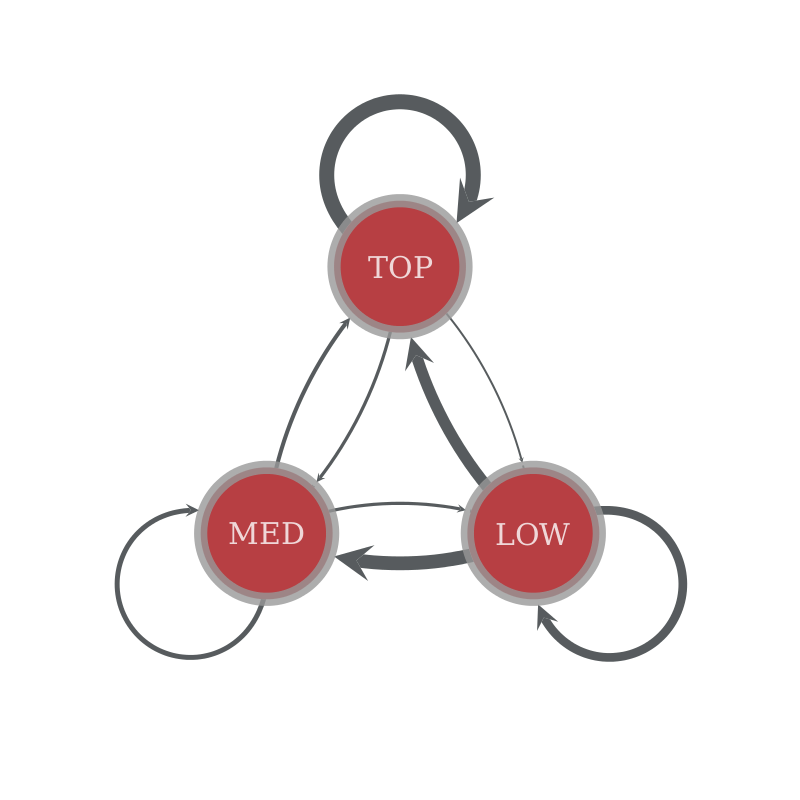

---rewired---
measure: in
max measure: 2134
min measure: 10
TOP limit: 117
MED limit: 33
categorize nodes
node dist
TOP 2534
MED 6595
LOW 23605
urls samples---------
MED
	 https://bar.wikipedia.org/wiki/Mahayana-Buddhismus
	 https://bar.wikipedia.org/wiki/Kategorie:User_fr-2
	 https://bar.wikipedia.org/wiki/Kategorie:R%C3%B6misch-katholischer_Geistlicher_(20._Jahrhundert)
	 https://bar.wikipedia.org/wiki/Liste_der_Staatsoberh%C3%A4upter_337
	 https://bar.wikipedia.org/wiki/Wunsiedel
	 https://bar.wikipedia.org/wiki/Januar
	 https://bar.wikipedia.org/wiki/Bras%C3%BClien
	 https://bar.wikipedia.org/wiki/Saudi_Arabien
	 https://bar.wikipedia.org/wiki/Kategorie:Artikel_auf_Oberbayerisch
	 https://bar.wikipedia.org/wiki/Biografien/Ch
TOP
	 https://bar.wikipedia.org/wiki/Clark_County,_Kentucky
	 https://bar.wikipedia.org/wiki/Taylor_County_(Iowa)
	 https://bar.wikipedia.org/wiki/Yoakum_County
	 https://bar.wikipedia.org/wiki/Liste_der_St%C3%A4dte_in_Deutschland
	 https://bar.wikipedia.org/wi

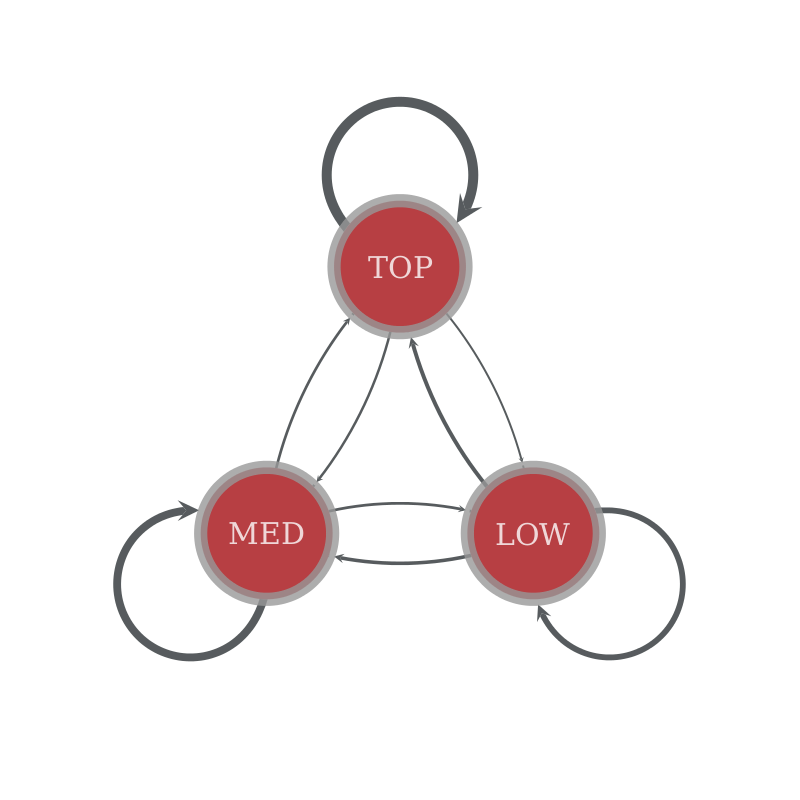

weight edges
draw biased graph


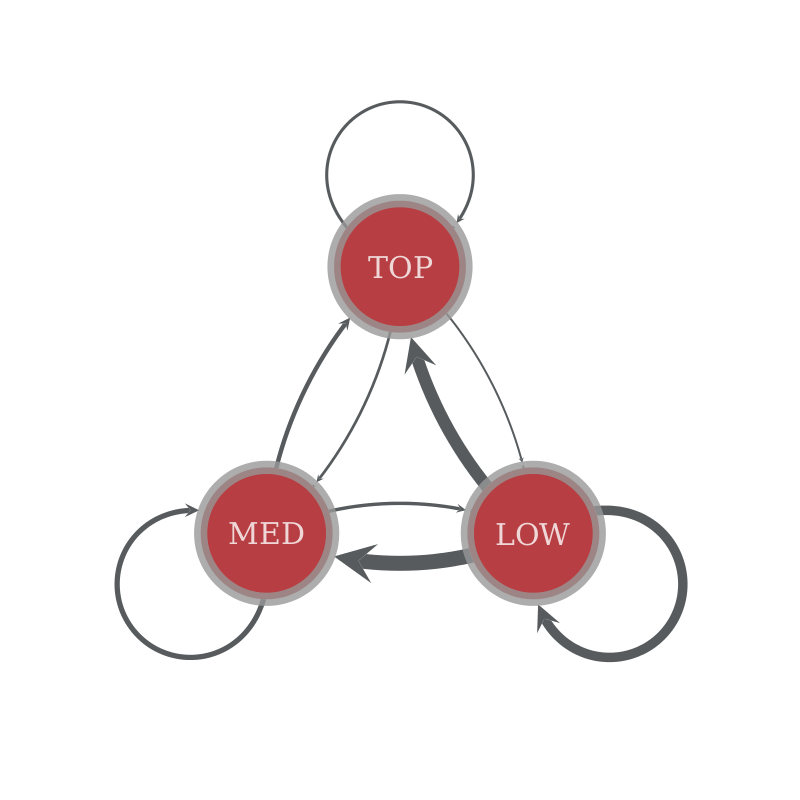

weight edges
draw biased graph


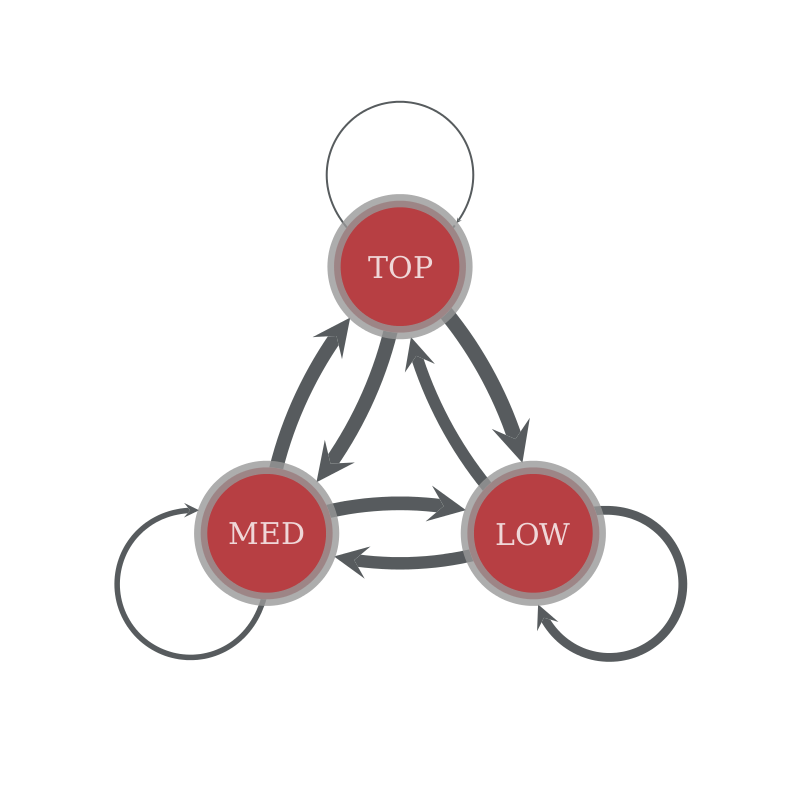

weight edges
draw biased graph


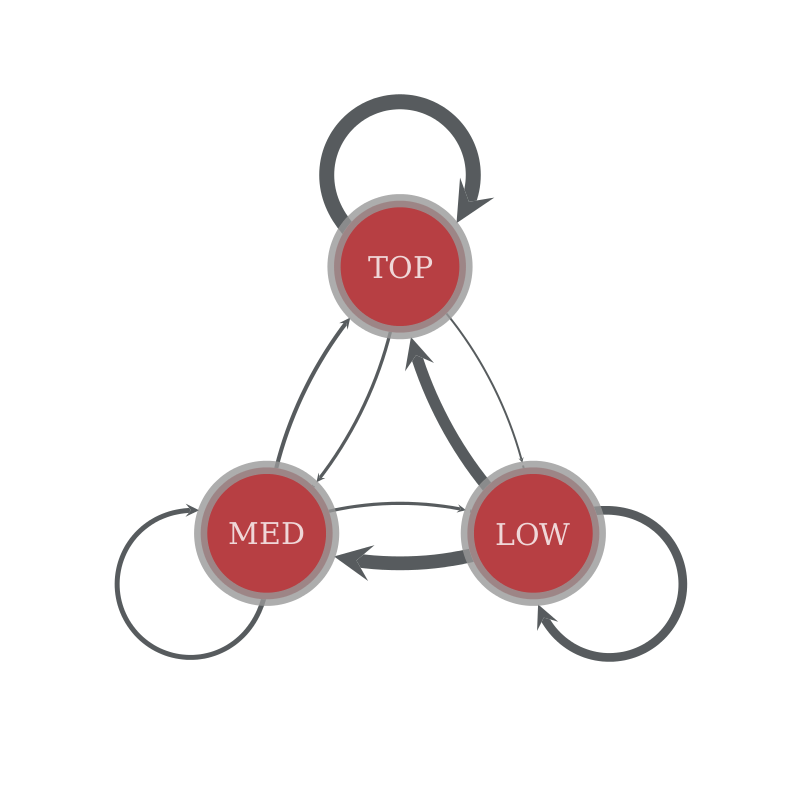

===================================tvthek_orf===================================
get network: tvthek_orf
	 tvthek_orf : 9799 v 301844 e
measure: in
max measure: 196
min measure: 12
TOP limit: 37
MED limit: 28
categorize nodes
node dist
TOP 1861
MED 3230
LOW 4708
urls samples---------
MED
	 http://tvthek.orf.at/index.php/program/heute-oesterreich/4660163/heute-oesterreich/10140046
	 http://tvthek.orf.at/index.php/program/ZIB-20/1218/ZIB-20/10159475/Signation-Themen/10159834
	 http://tvthek.orf.at/topic/Kultur/6275545/heute-oesterreich/10166042/FIFA-Platzierung-Allzeithoch-fuer-Nationalmannschaft/10166340
	 http://tvthek.orf.at/program/ZIB-1-OeGS/145302/ZIB-1-OeGS/10149937/Hitze-am-Hoehepunkt/10150027
	 http://tvthek.orf.at/topic/Griechenland-Krise/10074203/ZIB-1300/10155189/Boerse-Griechen-Drama-kostet-Oesterreich-Milliarden/10155420
	 http://tvthek.orf.at/program/Wien-heute/70018/Wien-heute/10138075/Verabschiedung/10141011
	 http://tvthek.orf.at/topic/Leben-und-Lifestyle/7174244/heute-

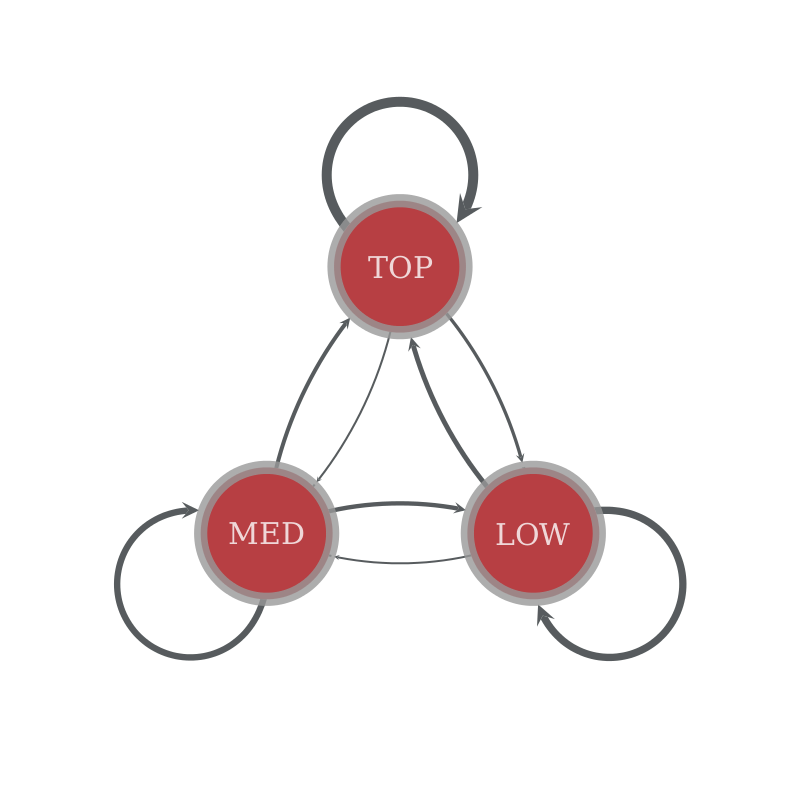

weight edges
draw biased graph


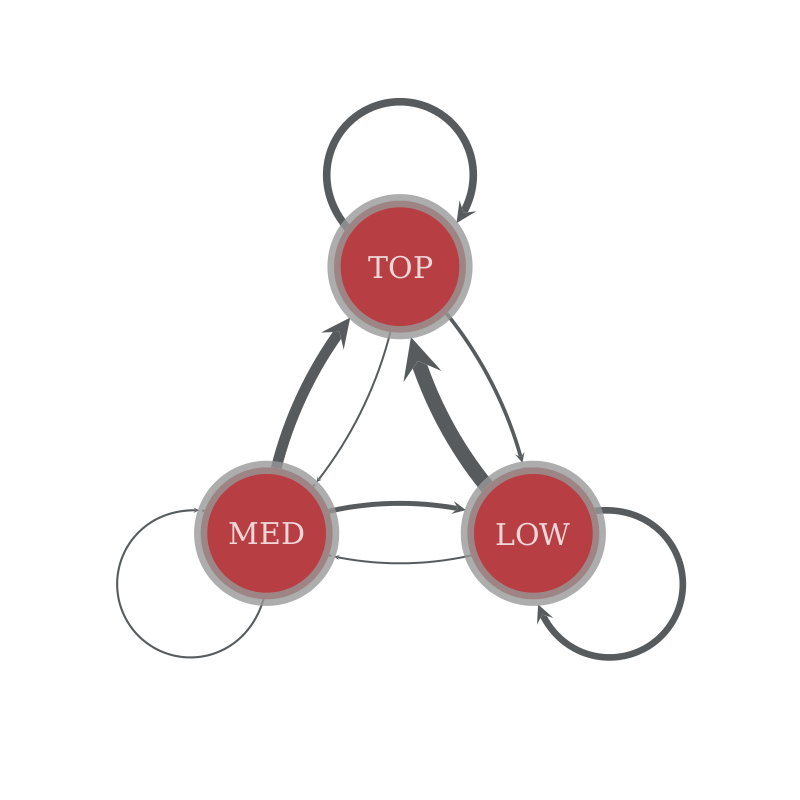

weight edges
draw biased graph


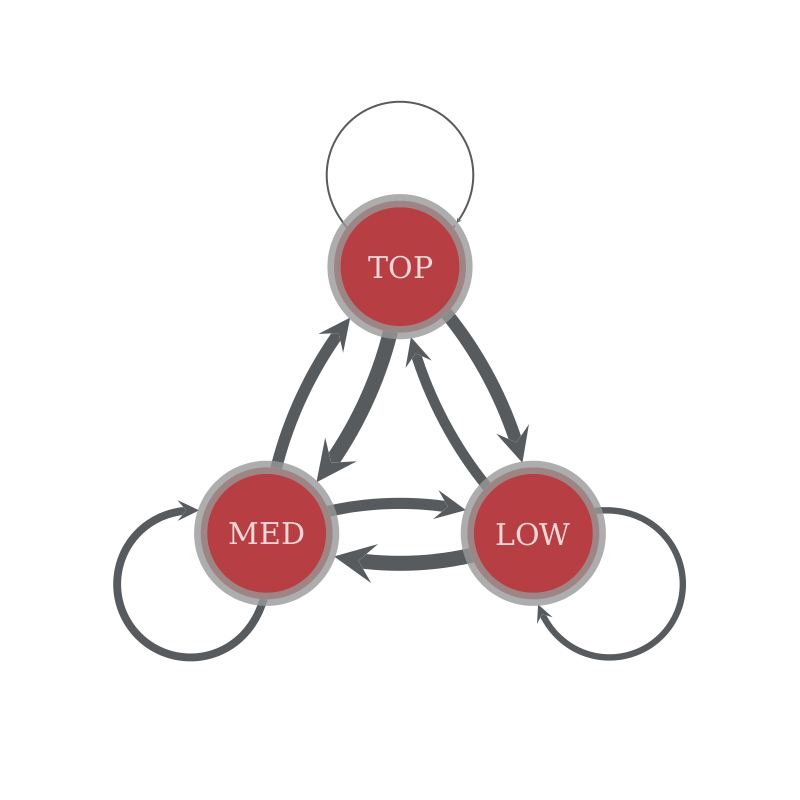

weight edges
draw biased graph


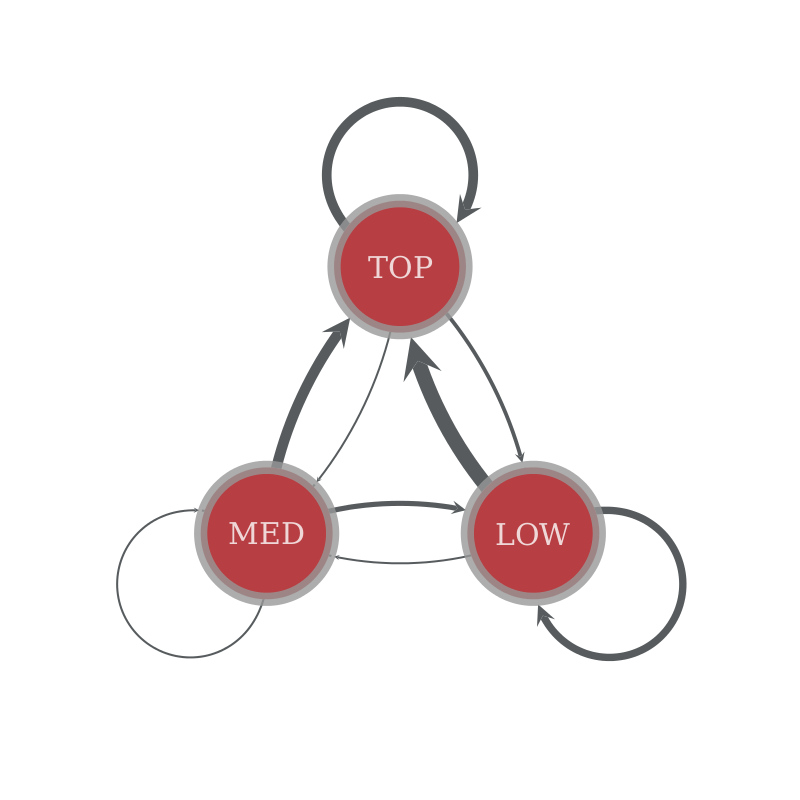

---rewired---
measure: in
max measure: 196
min measure: 12
TOP limit: 37
MED limit: 28
categorize nodes
node dist
TOP 1861
MED 3230
LOW 4708
urls samples---------
MED
	 http://tvthek.orf.at/index.php/topic/Kultur/6275545/heute-oesterreich/10166042/Hinweis-Verabschiedung/10166341
	 http://tvthek.orf.at/program/heute-leben/4660213/heute-leben/10146844/Kochen-Wurzelkarpfen-2/10149034
	 http://tvthek.orf.at/program/ZIB-1-OeGS/145302/ZIB-1-OeGS/10178701/Hinweis-Verabschiedung/10178876
	 http://tvthek.orf.at/program/Kultur-heute/3078759/Kultur-Heute/10148037/Jazzgroessen-beim-Fernwaerme-Open-Air/10153544
	 http://tvthek.orf.at/index.php/program/ZIB-1700/71284/ZIB-1700/10172732
	 http://tvthek.orf.at/program/Niederoesterreich-heute/70017/Niederoesterreich-heute/10176485
	 http://tvthek.orf.at/program/ZIB-900/71256/ZIB-900/10171461/Weitere-400-Fluechtlinge-werden-aufgenommen/10171471
	 http://tvthek.orf.at/program/Oberoesterreich-heute/70016/Oberoesterreich-heute/10176493/Radevents-und-Ritterf

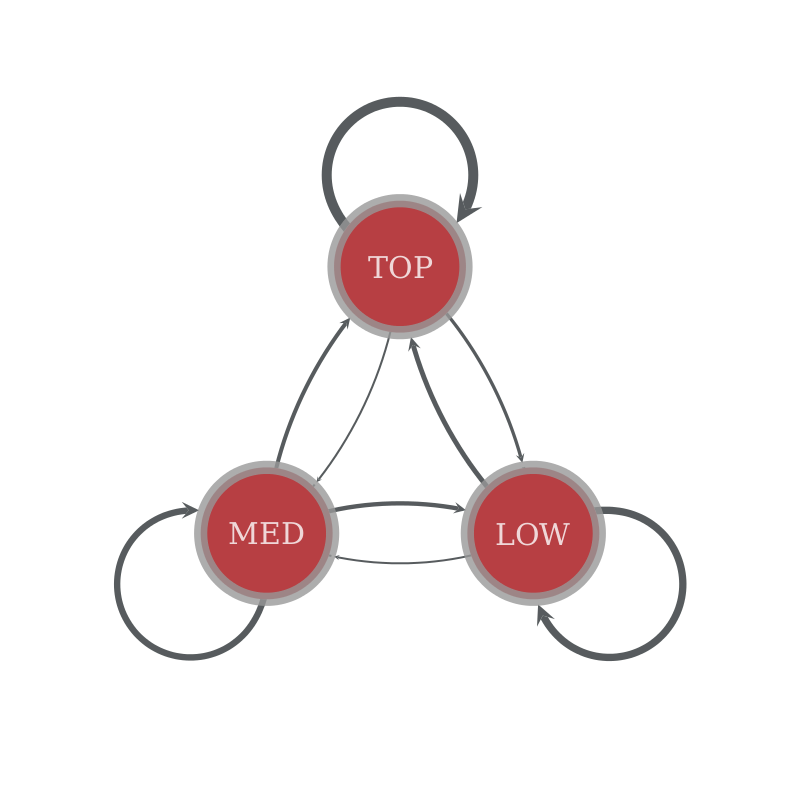

weight edges
draw biased graph


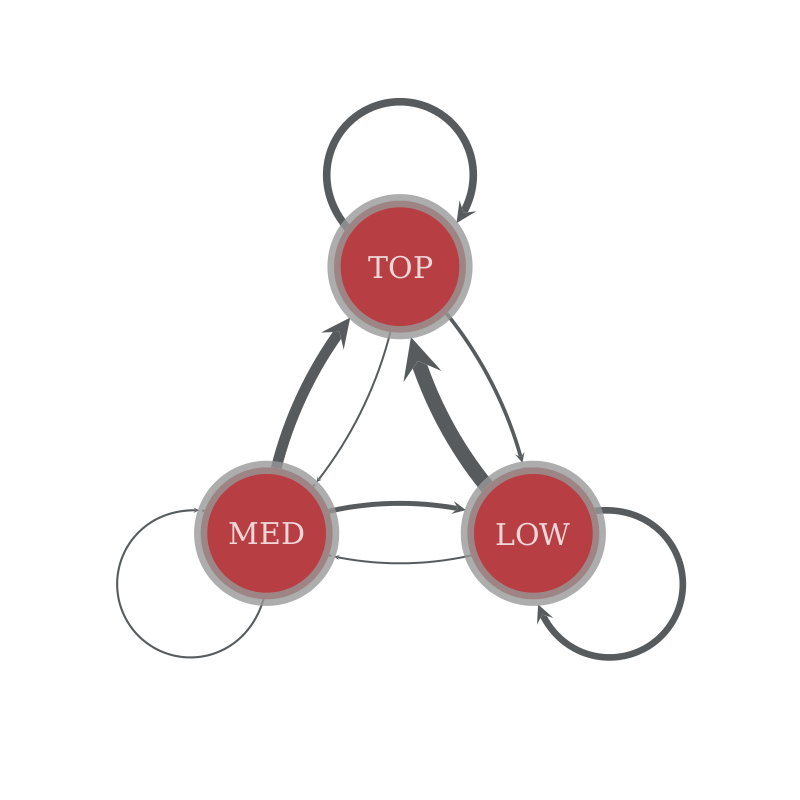

weight edges
draw biased graph


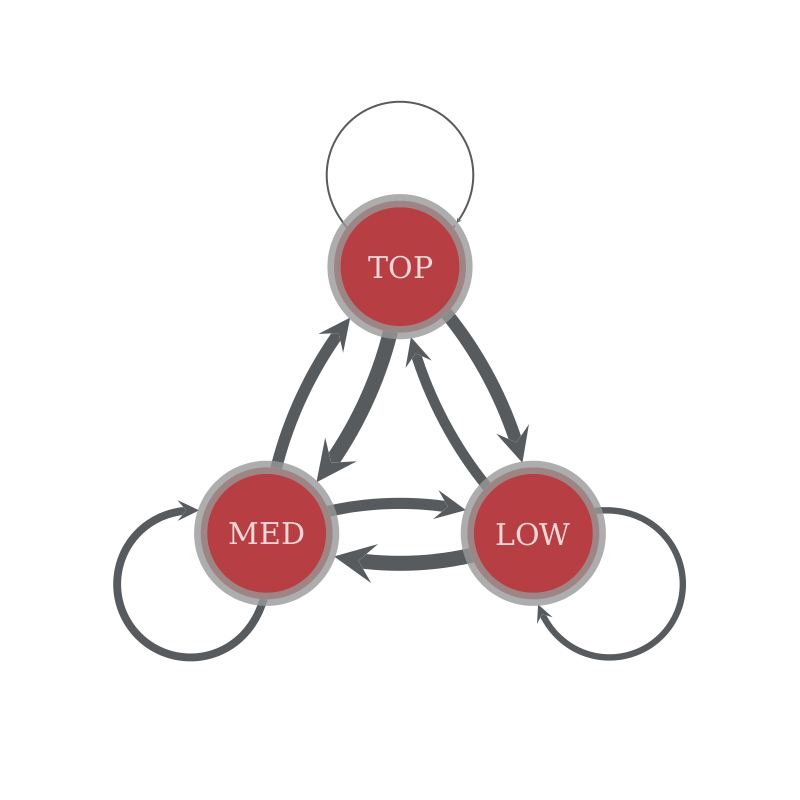

weight edges
draw biased graph


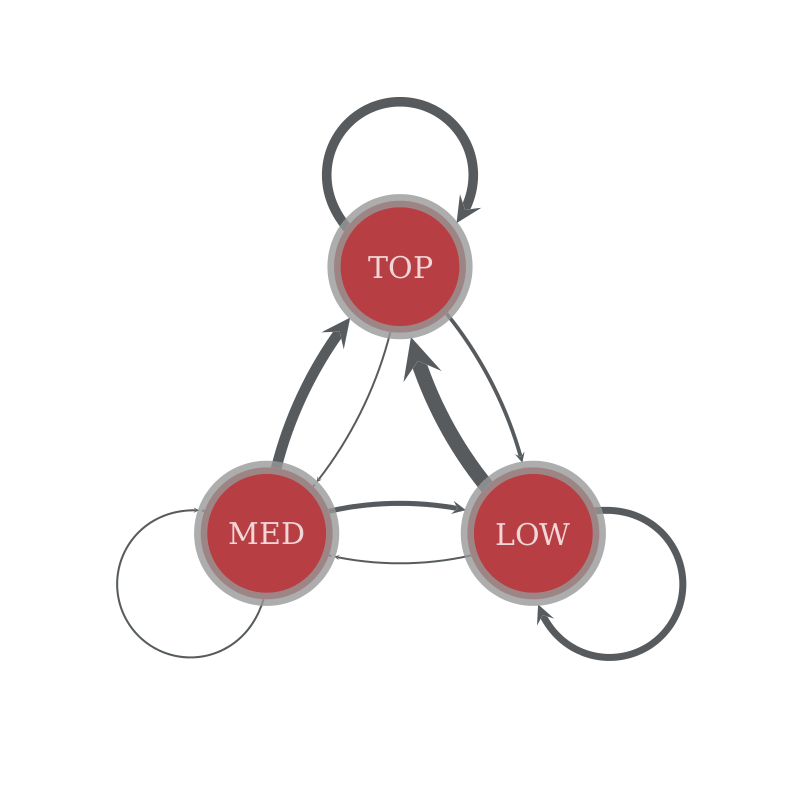

====================================daserste====================================
get network: daserste
	 daserste : 70063 v 3448513 e
measure: in
max measure: 189
min measure: 1
TOP limit: 59
MED limit: 44
categorize nodes
node dist
TOP 20834
MED 29862
LOW 19367
urls samples---------
MED
	 http://mediathek.daserste.de/Tagesschau-mit-Gebärdensprache/tagesschau-mit-Gebärdensprache-20-00-Uh/Das-Erste/Video?documentId=16896326&topRessort&bcastId=12722002&mpage=page.info
	 http://mediathek.daserste.de/Brennpunkt/Brennpunkt-Zu-Guttenberg-tritt-ab/Das-Erste/Video?documentId=9969714&topRessort&bcastId=1082266
	 http://mediathek.daserste.de/Morgenmagazin/Preuß-und-Schempp-gewinnen-City-Biathlon/Das-Erste/Video?documentId=25599022&topRessort&bcastId=435054&mpage=page.info
	 http://mediathek.daserste.de/REPORT-MAINZ/REPORT-MAINZ-fragt-Prof-Anne-Dore-Stein/Das-Erste/Video?documentId=19999304&topRessort&bcastId=310120
	 http://mediathek.daserste.de/Morgenmagazin/Kegeln-Leistungssport-trotz-Schatten

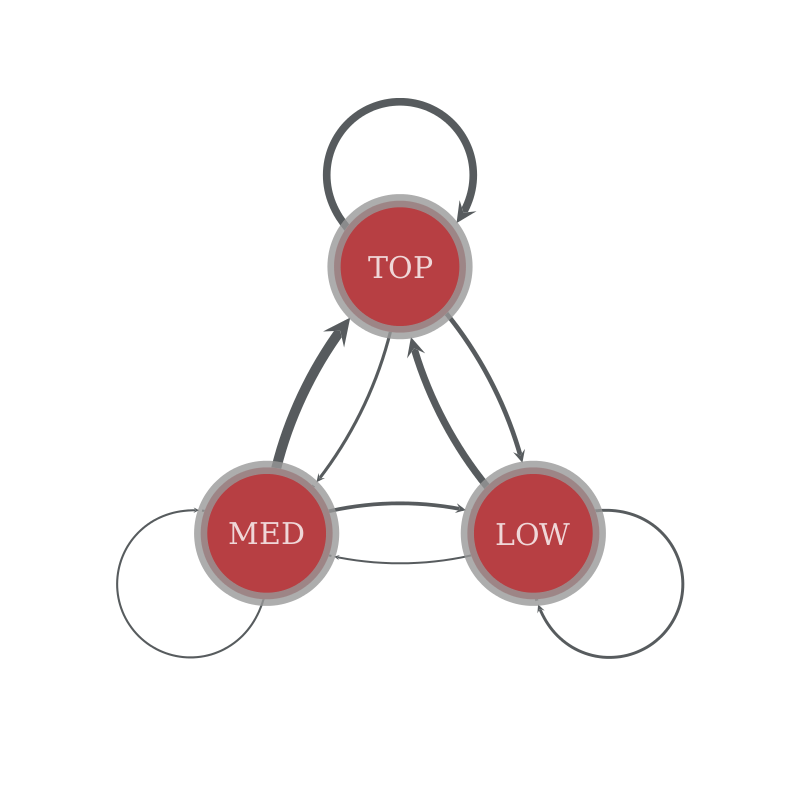

weight edges
draw biased graph


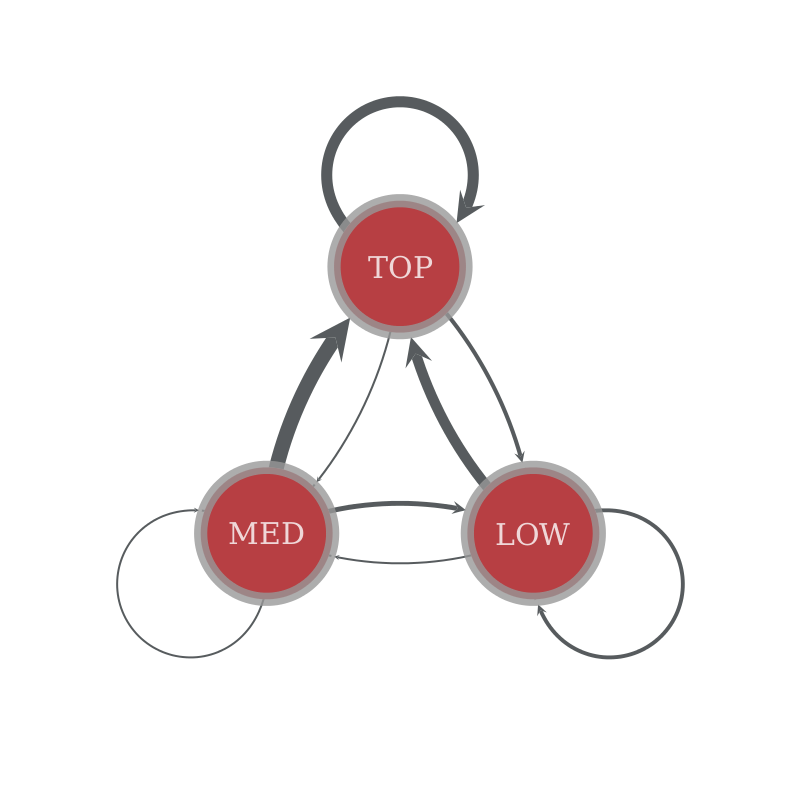

weight edges
draw biased graph


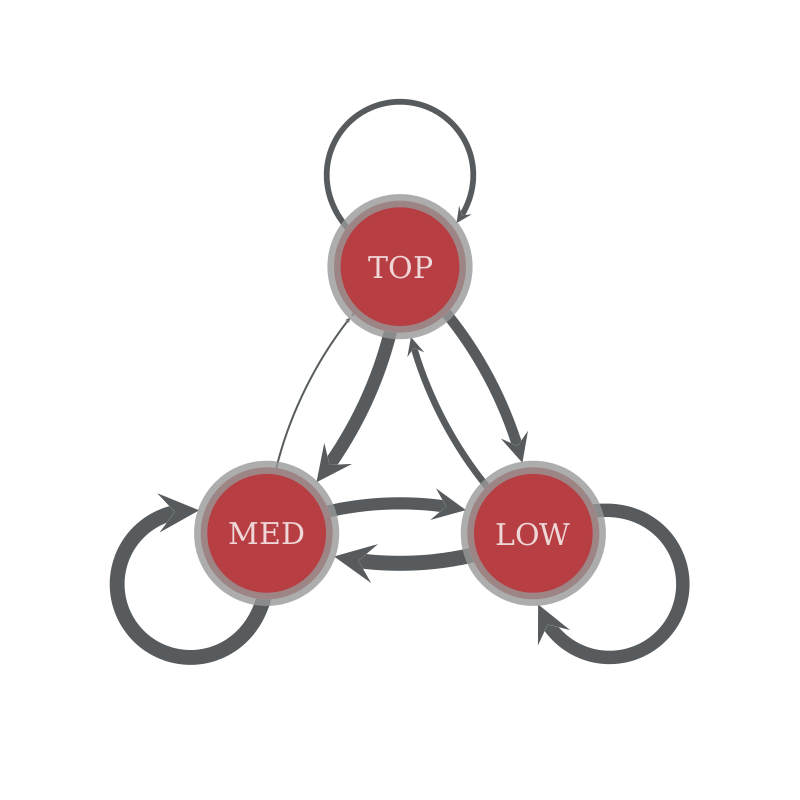

weight edges
draw biased graph


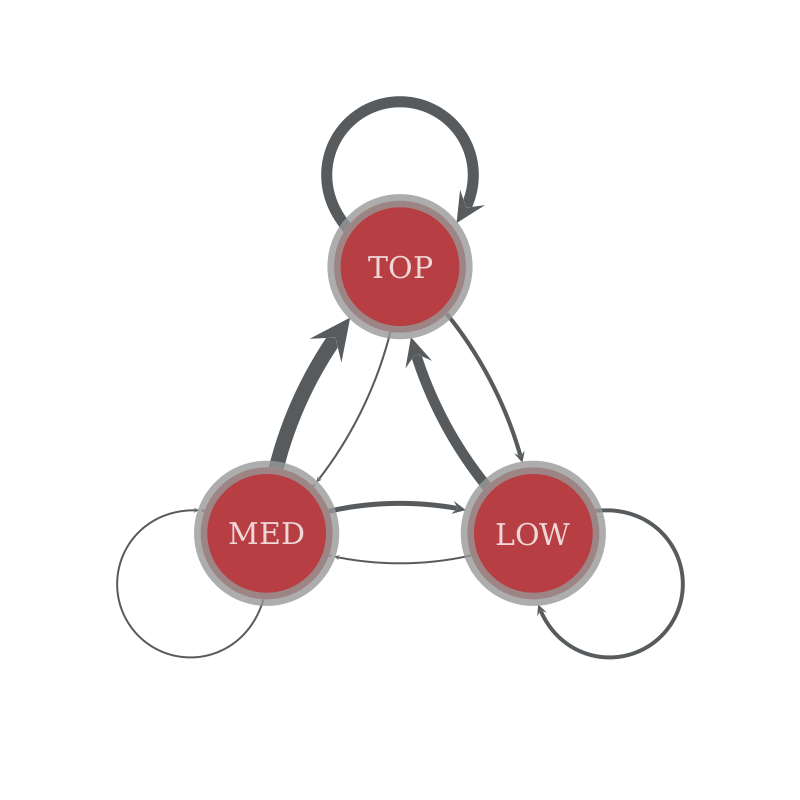

---rewired---
measure: in
max measure: 189
min measure: 1
TOP limit: 59
MED limit: 44
categorize nodes
node dist
TOP 20834
MED 29862
LOW 19367
urls samples---------
MED
	 http://mediathek.daserste.de/Druckfrisch/Pfaueninsel-von-Thomas-Hettche/Das-Erste/Video-Podcast?documentId=23354058&topRessort&bcastId=339944
	 http://mediathek.daserste.de/Tagesschau/tagesschau-15-05-Uhr/Das-Erste/Video?documentId=19062698&topRessort&bcastId=4326
	 http://mediathek.daserste.de/Tagesthemen/tagesthemen/Das-Erste/Video?documentId=18300194&topRessort&bcastId=3914&mpage=page.info
	 http://mediathek.daserste.de/Weltspiegel/Ukraine-Todesflug-MH-17-Die-Wut-der-Hi/Das-Erste/Video-Podcast?documentId=27933046&topRessort&bcastId=329478
	 http://mediathek.daserste.de/Mittagsmagazin/Börse/Das-Erste/Video?documentId=29031590&topRessort&bcastId=314636
	 http://mediathek.daserste.de/Mittagsmagazin/Wirtschaftsnews/Das-Erste/Video?documentId=29342296&topRessort&bcastId=314636&mpage=page.info
	 http://mediathek.daserste

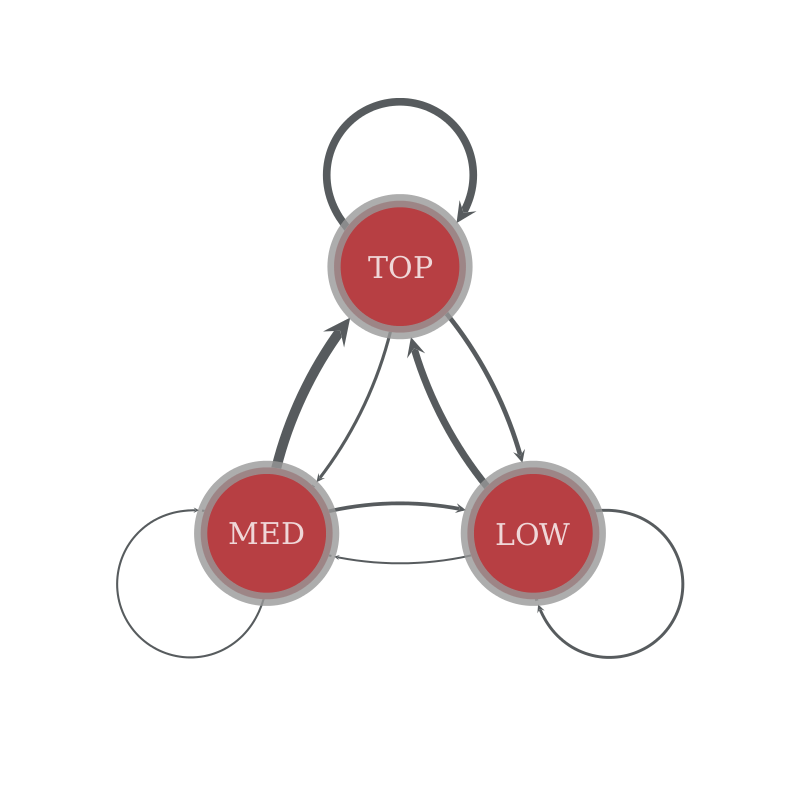

weight edges
draw biased graph


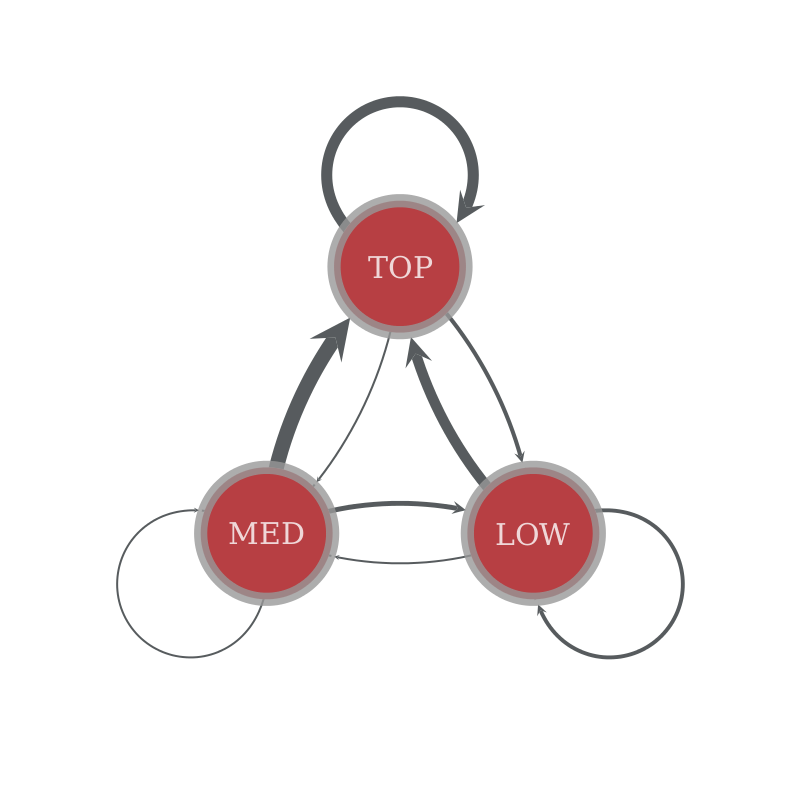

weight edges
draw biased graph


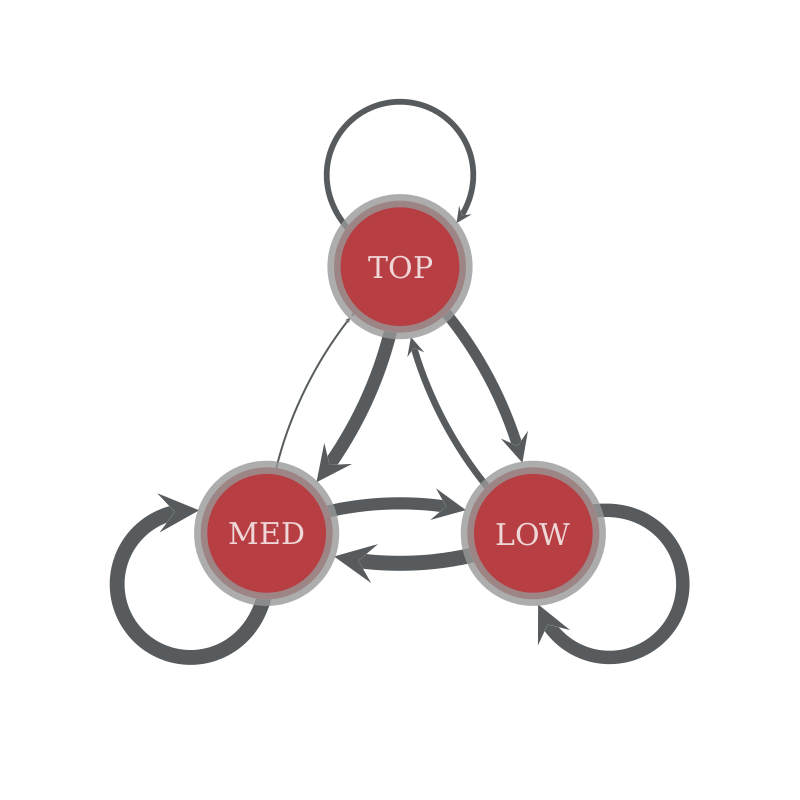

weight edges
draw biased graph


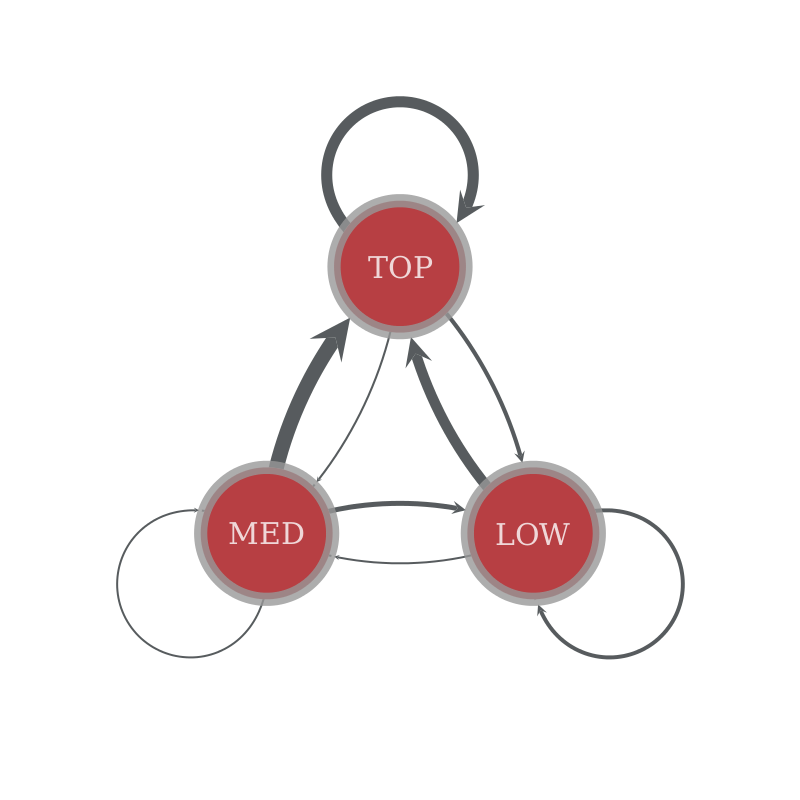

In [5]:
out_dir = 'struct_plots/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
for ds in datasets:
    cat_measure = 'out'
    network_name = ds['name']
    ds = ds.copy()
    ds.pop("name", None)
    file_name = network_name.rsplit('/', 1)[-1]
    print(file_name.center(80, '='))
    net = get_network(network_name, **ds)
    network_name, file_name = file_name, network_name
    print('\t', network_name, ':', net.num_vertices(), 'v', net.num_edges(), 'e')
    viz_net_struct(net, out_dir + network_name, measure = cat_measure, med_perc=33, high_perc=66)
    random_rewire(net, 'correlated')
    print('---rewired---')
    viz_net_struct(net, out_dir + network_name + '_rw', measure = cat_measure, med_perc=33, high_perc=66)
    # break